# Setup

Install in R:
```
install.packages("BiocManager")
BiocManager::install(c("edgeR", "BiocParallel", "RhpcBLASctl"))
```

Install

```pip install toytree ete4 pybiomart```

## Options & Data

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import re
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
import seaborn as sns
from scipy.sparse import issparse
from pymer4.models import lmer, lm, glmer, compare
from pymer4 import config
import polars
import statsmodels.api as sm
import senepy
import gseapy as gp
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np
import scflow
from scflow.ax import find_senescence_genes, run_senepy

# Display/Environment Settings
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
warnings.filterwarnings("ignore", message=".*ast.Ellipsis is deprecated.*")
config.PANDAS_BACKEND = True
warnings.filterwarnings("ignore", message=".*vert.*will be deprecated.*")
pd.set_option("display.max_rows", 500)  # or None for unlimited rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.width", 300)
warnings.filterwarnings(
    "ignore", message="Bitwise inversion '~' on bool is deprecated",
    category=DeprecationWarning)

# Process Options
ncpus = os.cpu_count() - 1
overwrite = True

# If You Want Results Emailed (Will Overwrite HTML Regardless of `overwite`)
cur_file = os.path.join(os.path.abspath(""), "analyze_senescence_celltype"
                        "_specific_threshold_612.ipynb")
html_out = os.path.splitext(cur_file)[0] + ".html"
email = "elizabeth.aslinger@aya.yale.edu"
# set email to None to skip

# Cell Type Label Column
col_celltype = "annotation_scanvi"
# col_celltype = "annotation_by_overlap"
# col_celltype = "Annotation_ToppGene"
# col_celltype = "cellmap_class_name"
# col_celltype = "cellmap_class_name_collapsed"
# use_hierarchy = False
collapse_neurons = True  # collapse neuron categories?

# Metadata Information
species = "Mouse"
col_condition = "Condition"
col_sample, col_batch = "sample", col_condition
# group_order = ["Ground Control | 12 Weeks", "Ground Control | 29 Weeks",
#                "Space Flight | 12 Weeks", "Space Flight | 29 Weeks"]
group_order = ["Ground Control", "Space Flight"]
keys = {col_condition: dict(key_control="Ground Control",
                            key_treatment="Space Flight"),
        col_batch: dict(key_control=group_order[0],
                        key_treatment=group_order[1])}
palette = {col_condition: {keys[col_condition]["key_control"]: "c",
                           keys[col_condition]["key_treatment"]: "tab:pink"},
           col_batch: {keys[col_condition]["key_control"]: "c",
                       keys[col_condition]["key_treatment"]: "tab:pink"}}

# Scoring Metrics
sen_metrics = ["senmayo"]
# sen_metrics = ["senepy", "senmayo"]
use_metric = "senmayo"
percentile = 1

# File Input & Output
file_path = "data/OSD-612_integrated.h5ad"
file_path_new = os.path.splitext(file_path)[0] + "_analyzed.h5ad"

# Load Data
self = scflow.Rna(file_path, col_sample=col_sample, col_batch=col_batch,
                  col_celltype=col_celltype)  # data
self.rna.obs.loc[:, col_batch] = self.rna.obs[col_batch].astype(
    pd.CategoricalDtype(categories=group_order, ordered=True))
self.rna = self.rna[:, self.rna.var.mt == False]  # snRNA-seq so remove MT-
self.rna = self.rna[:, self.rna.var.ribo == False]  # snRNA-seq so remove RB-
self.rna.obs.loc[:, "Spaceflight"] = (self.rna.obs[col_condition] == keys[
    col_condition]["key_treatment"]).astype(int)  # 1 vs. 0 spaceflight
self.rna.X = self.rna.layers["log1p"].copy()
self.rna.raw = None

# Hierarchical
keys_cts = {"Neurons": ["Excitatory", "Inhibitory",
                        "Excitatory-Inhibitory", "Neuron"],
            "Macroglia": ["Oligodendrocyte", "OPC", "Astrocyte"],
            "Microglia": ["Microglial"],
            "Endothelial Cell": ["Endothelial"]}
key_cts = dict(pd.concat([pd.Series(dict(([(i, x) for i in keys_cts[
    x]]))) for x in keys_cts]))
if collapse_neurons is True:
    self.rna.obs.loc[:, f"{col_celltype}_collapsed"] = self.rna.obs[
        col_celltype].replace(dict(zip(keys_cts["Neurons"], ["Neurons"] * 3)))
    col_celltype = f"{col_celltype}_collapsed"
    self.col_celltype = col_celltype
self.rna.obs.loc[:, f"{col_celltype}_hierarchy"] = self.rna.obs[
    col_celltype].replace(key_cts)

# Display Object
print(self.rna)
print(self.rna.obs.groupby(col_sample).describe())
self.rna.obs

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/senepy/load_hubs.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/__init__.py:17: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  __version_info__ = tuple(LooseVersion(__version__).version)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/fields.py:198: RemovedInMarshmallow4Warning: Passing field metadata as a keyword arg is deprecated. Use the explicit `metadata=...` argument instead.
  warnings.warn(


## Data Descriptives

In [2]:
%matplotlib inline

# Detect Metadata Columns in AnnData Object
metadata_cols = self.rna.obs.groupby(col_sample).apply(
    lambda x: list(x.columns[np.where(
        x.apply(lambda y: len(y.unique()) ==  1))[0]]))
metadata_cols = [x for x in metadata_cols.explode().unique() if all((
    x in metadata_cols.loc[i] for i in metadata_cols.index.values))]

# Value Counts for Categorical Variables
metadata_cols_category = self.rna.obs[metadata_cols].dtypes[((
    self.rna.obs[metadata_cols].dtypes == "category") | (self.rna.obs[
        metadata_cols].apply(lambda x: len(x.unique()) < 6))) & (self.rna.obs[
            metadata_cols].apply(lambda x: len(x.unique()) > 1))].index
for x in metadata_cols_category:
    print(x, "\n\n", self.rna.obs[x].value_counts(), "\n\n")
    if col_batch is not None:  # by batch
        if x != col_batch:
            print(x, "\n\n", self.rna.obs[[x, col_batch]].groupby(
                col_batch).value_counts(), "\n\n")

# Descriptives for Continuous Variables
print(self.rna.obs[self.rna.obs.columns.difference(
    metadata_cols_category)].describe())
if col_batch is not None:  # by batch
    print(self.rna.obs[list(self.rna.obs.columns.difference(
        metadata_cols_category)) + [col_batch]].groupby(col_batch).describe())

# Cells per Cluster
perc_clusters = round(100 * self.rna.obs.groupby(col_sample).value_counts(
    [col_celltype], normalize=True).unstack(1), 2)
print(f"\n\n*** Cell Composition (%) ***\n\n{perc_clusters}")

# Number of Cells
n_cells = self.rna.obs.groupby(col_sample).apply(
    lambda x: x.n_cells_original_sample.unique()[0],
    include_groups=False).to_frame("Original Cell N").join(
        self.rna.obs.groupby(col_sample).apply(
            lambda x: x.shape[0], include_groups=False).to_frame("N Cells"))
n_cells.loc[:, "Percent_Filtered"] = round(100 * (1 - n_cells[
    "N Cells"] / n_cells["Original Cell N"]), 2)
print("\n\n", n_cells.sort_values("Percent_Filtered"))

/tmp/ipykernel_635086/1416146960.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metadata_cols = self.rna.obs.groupby(col_sample).apply(


Group 

 Group
Ground Control    33095
Space Flight      29231
Name: count, dtype: int64 


Group 

 Condition       Group         
Ground Control  Ground Control    33095
                Space Flight          0
Space Flight    Space Flight      29231
                Ground Control        0
Name: count, dtype: int64 


sample 

 sample
RR10_BRN_GC_WT_G3     12739
RR10_BRN_FLT_WT_F1     9930
RR10_BRN_FLT_WT_F3     9550
RR10_BRN_GC_WT_G1      6826
RR10_BRN_GC_WT_G9      6823
RR10_BRN_FLT_WT_F7     3994
RR10_BRN_GC_WT_G5      3609
RR10_BRN_GC_WT_G7      3098
RR10_BRN_FLT_WT_F9     2924
RR10_BRN_FLT_WT_F5     2833
Name: count, dtype: int64 


sample 

 Condition       sample            
Ground Control  RR10_BRN_GC_WT_G3     12739
                RR10_BRN_GC_WT_G1      6826
                RR10_BRN_GC_WT_G9      6823
                RR10_BRN_GC_WT_G5      3609
                RR10_BRN_GC_WT_G7      3098
                RR10_BRN_FLT_WT_F1        0
                RR10_BRN_FLT_WT_F3        0


## Remove Cell Types Not in All Samples

In [3]:
ct_cts = self.rna.obs.groupby(col_sample).value_counts([
    col_celltype]).unstack(1).replace(np.nan, 0)
cts_in_all_samples = ct_cts.apply(lambda x: all(x > 1)).replace(
    False, np.nan).dropna().index.values
drop_cts = set(self.rna.obs[col_celltype]).difference(cts_in_all_samples)
ct_cts
if len(drop_cts) > 0:
    print(f"\nDropping cell types not present in all samples: {drop_cts}\n\n")
    self.rna = self.rna[self.rna.obs[col_celltype].isin(cts_in_all_samples)]
ct_cts


Dropping cell types not present in all samples: {'Neuroepithelial', 'Endothelial', 'Pericyte'}




annotation_scanvi_collapsed,Astrocyte,Endothelial,Neurons,Microglial,Neuroepithelial,OPC,Oligodendrocyte,Pericyte
sample,,,,,,,,
RR10_BRN_GC_WT_G5,279,4,2709,47,1,118,447,4
RR10_BRN_FLT_WT_F1,848,66,6959,132,3,347,1575,0
RR10_BRN_GC_WT_G1,587,38,4231,645,0,244,1073,8
RR10_BRN_GC_WT_G9,477,3,3875,871,33,722,833,9
RR10_BRN_FLT_WT_F3,609,1,6836,49,37,326,1690,2
RR10_BRN_GC_WT_G3,1185,1,8785,88,117,441,2121,1
RR10_BRN_FLT_WT_F7,405,24,2362,119,4,101,708,271
RR10_BRN_FLT_WT_F9,291,1,2106,32,3,102,334,55
RR10_BRN_FLT_WT_F5,254,17,1932,71,5,88,435,31


## Get Marker Gene Sets

From Google Drive, except senmayo derived from file downloaded from
https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/SAUL_SEN_MAYO.html
then created using:

```
from pybiomart import Server

senmayo = pd.read_csv("resources/SAUL_SEN_MAYO.v2025.1.Hs.tsv",
                      sep="\t", header=0)
senmayo = senmayo[senmayo.STANDARD_NAME == "GENE_SYMBOLS"]
senmayo = pd.Series({"Senmayo": senmayo.iloc[0, 1].split(
    ",")}, name="symbol").rename_axis("Gene_Set").explode().str.strip(
        ).replace("", np.nan).dropna().to_frame()
server = Server(host="http://www.ensembl.org")
mart = server.marts["ENSEMBL_MART_ENSEMBL"] # Access the Ensembl mart
human_dataset = mart.datasets["hsapiens_gene_ensembl"]
orthologs = human_dataset.query(attributes=[
    "external_gene_name", "mmusculus_homolog_associated_gene_name"])
orthologs = orthologs.dropna().set_index(orthologs.columns[0])
orthologs = orthologs.loc[orthologs.index.intersection(
    senmayo.symbol.to_list())].iloc[:, 0]
print(f"{orthologs.shape[0]} orthologs found out of"
      f" {len(senmayo.symbol.unique())} senmayo genes")
senmayo = senmayo.assign(symbol=senmayo.replace({"symbol": dict(zip(
    orthologs.index, orthologs.values))}))
senmayo.to_csv("gene_sets/senmayo.csv")
```

(Also could use `scflow.tl.convert_gene_species(senmayo.symbol.to_list())`)

Certain gene sets created from Google Drive ADBR AWG > Projects > White Matter > Gene Sets files (with the suffix = "_adjusted") were modified for consistency, e.g.,

```
pd.read_csv("gene_sets/_iron_genes_gmt_out.csv", index_col=[
    0, 1]).rename_axis(["row_id", "pathway"]).stack().to_frame(
        "symbol").reset_index(-1, drop=True).reset_index().to_csv(
            "gene_sets/_iron_genes_gmt_out_adjusted.csv")
```


### *A Priori*

In [4]:
mks = [pd.read_csv(os.path.join("gene_sets", i)).dropna(
    how="all", axis=1).assign(Source_File=i) for i in os.listdir("gene_sets")]
mks = [x.assign(Gene_Set=x["Source_File"].iloc[0].split("_2025")[0]) if (
    "pathway" in x) else x for x in mks]
mks = pd.concat(mks).drop("Unnamed: 0", axis=1).drop("row_id", axis=1)
mks = mks[mks.symbol.isin(self.rna.var_names)]
mks = mks[["Gene_Set", "symbol"]].set_index("Gene_Set").groupby(
    "Gene_Set").apply(lambda x: x["symbol"].to_list())
marker_genes_dict = dict(mks)
marker_gene_sets = mks.copy()
print(marker_gene_sets)

Gene_Set
GOBP_CELLULAR_RESPONSE_TO_IRON_ION                                                                                                                                                                                                               [B2m, Bmp6, Gpld1, Hfe, Ireb2, Tfr2, Tfrc, Trf]
GOBP_CENTRAL_NERVOUS_SYSTEM_MYELIN_FORMATION                                                                                                                                                                                                      [Abca2, Ckap5, Cntn1, Ercc2, Mag, Mios, Tenm4]
GOBP_INTRACELLULAR_IRON_ION_HOMEOSTASIS                                                                                                                                                      [Abcb7, Aco1, Alas2, Atp13a2, Atp6ap1, Atp6v0a2, Atp6v0d1, Atp6v1a, Atp6v1g1, B2m, Bmp6, Bmyc, B...
GOBP_IRON_COORDINATION_ENTITY_TRANSPORT                                                                                     

### Clusters in Data

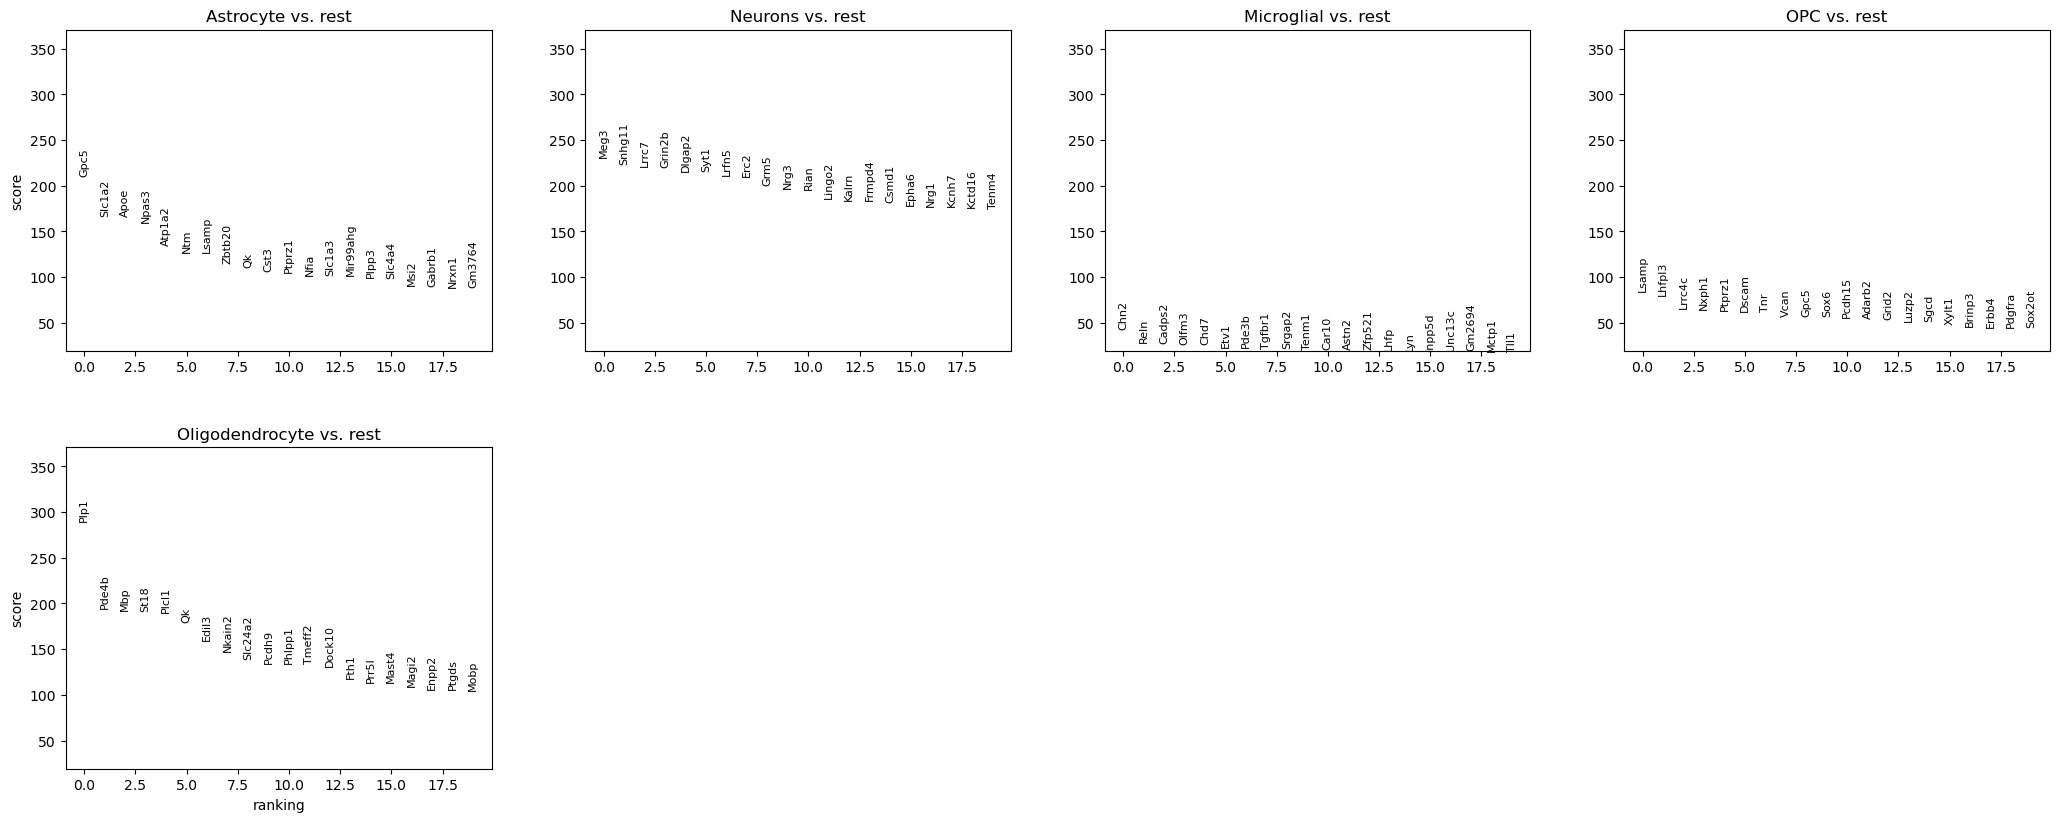

scores  logfoldchanges          pvals      pvals_adj
annotation_scanvi_collapsed annotation_scanvi_collapsed names                                                            
Astrocyte                   Astrocyte                   Gpc5     209.987823        6.742071   0.000000e+00   0.000000e+00
                                                        Slc1a2   166.273193        5.374050   0.000000e+00   0.000000e+00
                                                        Apoe     166.212997        5.384736   0.000000e+00   0.000000e+00
Microglial                  Microglial                  Chn2      42.755180        3.870991  7.557118e-288  3.712132e-286
                                                        Reln      28.332344        2.935601  7.413217e-150  1.743119e-148
                                                        Cadps2    27.266808        2.337426  1.440579e-140  3.201866e-139
Neurons                     Neurons                     Phf20l1   47.856068        1.036686   0.000000e+00   0.000000e+00
                                                        Ephx4     47.682915        2.268625   0.000000e+00   0.000000e+00
                                                        Spata7    47.707535        1.537675   0.000000e+00   0.000000e+00
OPC                         OPC                         Lsamp     84.650322        1.581869   0.000000e+00   0.000000e+00
                                                        Lhfpl3    79.807152        4.267320   0.000000e+00   0.000000e+00
                                                        Lrrc4c    65.868347        2.023771   0.000000e+00   0.000000e+00
Oligodendrocyte             Oligodendrocyte             Plp1     289.653320        7.352560   0.000000e+00   0.000000e+00
                                                        Pde4b    195.356369        3.856542   0.000000e+00   0.000000e+00
                                                        Aplp1     73.565163        2.454121   0.000000e+00   0.000000e+00

In [5]:
self.find_markers(col_celltype=col_celltype)
df_celltype_markers = self.get_markers_df(
    n_genes=50, col_celltype=col_celltype,
    log2fc_threshold=1, p_threshold=1e-10)
df_celltype_markers.groupby(col_celltype).apply(lambda x: x.head(3))

# Regress Out?

In [6]:
# if vars_regress_out is not None:
#     self.rna.X = self.rna.layers["log1p"].copy()
#     sc.pp.regress_out(self.rna, vars_regress_out)
#     self.rna.layers["log1p"] = self.rna.X.copy()
#     pkg.pp.scale(self.rna, zero_center=True, max_value=10)
#     self.rna.layers["scaled"] = self.rna.X.copy()
#     self.rna.X = self.rna.layers["log1p"].copy()

# Score Senescence

## Run Scoring

If you want just to find the senescence-related genes, run:

```
tissue = "Brain"  # or whatever you want here
celltype = None  # or whatever you want here
genes_senepy, hubs, figs = find_senescence_genes(
    self.rna, species=species, tissue=tissue, celltype=celltype,
    overlap_threshold=0, literature_sources=None,
    sengpt_sources=True, plot=True, col_celltype=col_celltype
)  # find tissue- and/or cell type-specific genes
```

To see available hubs:

```
hubs = senepy.load_hubs(species=species)
hubs.metadata.set_index(["tissue", "cell"]).sort_index()
```

Other examples of arguments you could use:

```
# tissue = ["Brain", "Myeloid"]
# tissue = None

# celltype = "GABA interneuron"  # only human I think
# celltype = ["microglia", "t cell", "monocyte"]
# celltype = "microglia"
# celltype = "microglial cell"`

### Senepy

In [7]:
%%time

tissue = "Brain"
celltype = None  # use all cell types

if "senepy" in sen_metrics:
    self.rna.X = self.rna.layers["log1p"].copy()
    self.rna, genes_senepy, figs = run_senepy(
        self.rna, species=species, tissue=tissue, celltype=celltype,
        overlap_threshold=0, literature_sources=None,
        sengpt_sources=True, col_celltype=col_celltype,
        col_senscore="score_senepy", identifiers=[col_celltype],
        use_translator=True, plot=True, figsize=(20, 20),
        swap_axes=False, standard_scale="group", plot_layer="log1p"
    )  # find tissue- and/or cell type-specific genes
    self.rna.obs.loc[
        :, "score_senepy_original_scale"] = self.rna.obs.score_senepy
    self.rna.obs.loc[:, "score_senepy"] = np.log(
        self.rna.obs.score_senepy)  # log-transform senescence score
    self.rna.obs[["score_senepy"]]

CPU times: user 5 μs, sys: 5 μs, total: 10 μs
Wall time: 94.4 μs


### Senmayo

In [8]:
if "senmayo" in sen_metrics:
    sc.tl.score_genes(self.rna, marker_gene_sets.loc["Senmayo"],
                      ctrl_as_ref=True, ctrl_size=50, gene_pool=None,
                      n_bins=25, score_name="score_senmayo", random_state=0,
                      copy=False, layer="log1p", use_raw=False)

## Label SnCs

### Define Snc Threshold & Label Cells

Based on percentile threshold derived from control group

In [9]:
# Determine Threshold
perc_s, perc = str(100 - percentile) + "%", 1 - (percentile / 100)
p_h = 3
perc_s_h, perc_h = str(100 - p_h) + "%", 1 - (p_h / 100)
print("Percentile for Threshold:", perc_s)
for u in sen_metrics:
    self.rna.obs = self.rna.obs.join(self.rna.obs[self.rna.obs[
        col_batch] == keys[col_batch]["key_control"]].groupby(
            col_celltype).apply(lambda x: x[f"score_{u}"].describe(
                percentiles=[perc])[perc_s], include_groups=False).to_frame(
                    f"Senescence_Threshold_{u}"), on=col_celltype).loc[
                        self.rna.obs.index]
    self.rna.obs = self.rna.obs.join(self.rna.obs[self.rna.obs[
        col_batch] == keys[col_batch]["key_control"]].groupby(
            col_celltype).apply(lambda x: x[f"score_{u}"].describe(
                percentiles=[perc_h])[perc_s_h],
                                include_groups=False).to_frame(
                                    f"Senescence_Threshold_{u}_{p_h}"),
                                on=col_celltype).loc[self.rna.obs.index]

# Binary CLassification
for x in sen_metrics:
    self.rna.obs.loc[:, f"Senescent_Cell_{x}"] = (self.rna.obs[
        f"score_{x}"] >= self.rna.obs[f"Senescence_Threshold_{x}"])
    self.rna.obs.loc[:, f"Senescent_Cell_{x}_{p_h}"] = (self.rna.obs[
        f"score_{x}"] >= self.rna.obs[f"Senescence_Threshold_{x}_{p_h}"])

# String Labels (for Plotting/Categorical Analysis)
for x in sen_metrics:
    self.rna.obs.loc[:, f"Senescent_Cell_Label_{x}"] = self.rna.obs[
        f"Senescent_Cell_{x}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_hierarchy_{x}"] = self.rna.obs[
        f"Senescent_Cell_{x}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_{x}_{p_h}"] = self.rna.obs[
        f"Senescent_Cell_{x}_{p_h}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_by_Type_{x}"] = self.rna.obs[
        f"Senescent_Cell_Label_{x}"].replace({
            "Senescent": "SnC ", "Non-Senescent": ""}) + self.rna.obs[
                col_celltype].astype(str)
    self.rna.obs.loc[:, f"SnC_hierarchy_{x}"] = self.rna.obs[
        f"Senescent_Cell_Label_{x}"].replace({
            "Senescent": "SnC ", "Non-Senescent": ""}) + self.rna.obs[
                col_celltype + "_hierarchy"].astype(str)

# Descriptives
for x in sen_metrics:
    print(x, round(self.rna.obs[[
        f"Senescent_Cell_Label_{x}", col_celltype]].value_counts(
            normalize=True).sort_index() * 100, 1).unstack(0))

# Choose Metrics for Main Analysis
for x in ["Senescent_Cell_Label", "Senescent_Cell", "SnC_hierarchy",
            "Senescence_Threshold", "Senescent_Cell_Label_by_Type"]:
    self.rna.obs.loc[:, x] = self.rna.obs[f"{x}_{use_metric}"]
self.rna.obs.loc[:, "senscore"] = self.rna.obs[f"score_{use_metric}"]
self.rna.obs.loc[
    :, f"Senescent_Cell_Label_by_Type_{use_metric}_{p_h}"] = self.rna.obs[
        f"Senescent_Cell_Label_{use_metric}_{p_h}"].replace({
            "Non-Senescent": "", "Senescent": "SnC "}).astype(
                str) + self.rna.obs[
                    col_celltype].astype(str)  # lower threshold SnC by type
genes = marker_gene_sets.loc["Senmayo"] if (
    use_metric == "senmayo") else genes_senepy  # main senescence gene list

# Avoid Nesting Duplication Issues
self.rna.obs.loc[:, "SnC_hierarchy"] = self.rna.obs[
    "SnC_hierarchy"].replace({
        "Neuron": "Neurons", "SnC Neuron": "SnC Neurons"})

Percentile for Threshold: 99%
senmayo Senescent_Cell_Label_senmayo  Non-Senescent  Senescent
annotation_scanvi_collapsed                           
Astrocyte                               8.4        0.1
Neurons                                67.9        0.6
Microglial                              3.3        0.0
OPC                                     4.2        0.0
Oligodendrocyte                        15.4        0.1


### Label Batch/Cell-Specific Senescence Percentiles

In [ ]:
# for x in ["Senescence_Label", "Senescence_CellType"]:
#     if x in self.rna.obs:
#         self.rna.obs = self.rna.obs.drop(x, axis=1)

# # %ile Thresholds (Overall)
# thresh = self.rna.obs["score_senepy"].describe(
#     percentiles=[0.90, 0.95, 0.99])
# thres_ct =  self.rna.obs[["score_senepy", col_celltype]].groupby(
#     col_celltype).describe(percentiles=[0.90, 0.95, 0.99])["score_senepy"]

# sen = self.rna.obs["score_senepy"].apply(
#     lambda x: "Top 1%" if x >= float(thresh.loc["99%"]) else "Top 5%" if (
#         x >= float(thresh.loc["95%"])) else "Top 10%" if x >= float(
#             thresh.loc["90%"]) else "Bottom 90%").to_frame(
#                 "Senescence_Label").loc[self.rna.obs.index]
# self.rna.obs = self.rna.obs.join(sen).loc[self.rna.obs.index]

# # %ile Thresholds (by Cell Type)
# sct = self.rna.obs.groupby(
#     col_celltype).apply(lambda g: g["score_senepy"].apply(
#         lambda x: f"Top 1% {g.name}" if x >= float(thres_ct.loc[g.name][
#             "99%"]) else f"Top 5% {g.name}" if (x >= float(thres_ct.loc[
#                 g.name]["95%"])) else f"Top 10% {g.name}" if x >= float(
#                     thres_ct.loc[g.name]["90%"]) else g.name),
#                         include_groups=False)

# sct = sct.to_frame("Senescence_CellType").reset_index(0, drop=True)
# sct = sct.loc[self.rna.obs.index]
# self.rna.obs = self.rna.obs.join(sct).loc[self.rna.obs.index]

# for x in ["Senescence_Label", "Senescence_CellType"]:
#     self.rna.obs = self.rna.obs.assign(**{
#         x: self.rna.obs[x].astype("category")})

# high_sen_cts = [i for i in self.rna.obs["Senescence_CellType"].unique(
#     ) if " 1% " in i]

### Descriptives of SnCs

Percent Senescent: 

 Senescent_Cell                      0                                                   1                                         
annotation_scanvi_collapsed Astrocyte Neurons Microglial    OPC Oligodendrocyte Astrocyte Neurons Microglial   OPC Oligodendrocyte
Condition                                                                                                                         
Ground Control                  98.99   99.00      98.98  98.96           99.00      1.01    1.00       1.02  1.04            1.00
Space Flight                    99.25   99.26      97.52  98.65           99.43      0.75    0.74       2.48  1.35            0.57


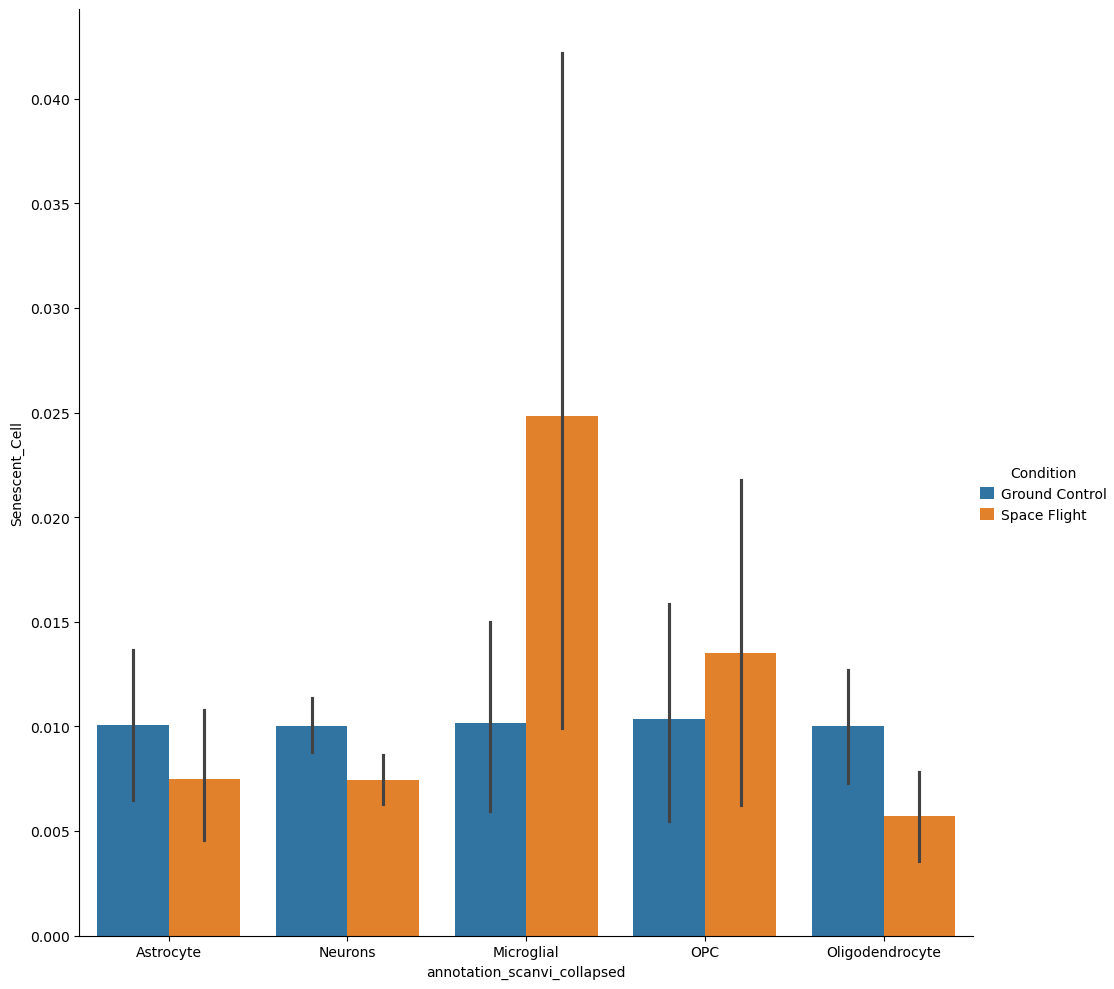

In [10]:
print("Percent Senescent: \n\n", round(self.rna.obs.groupby([
    col_celltype, col_batch]).apply(lambda x: x["Senescent_Cell"].astype(
        int).value_counts(normalize=True), include_groups=False) * 100,
    2).unstack(col_celltype))
sns.catplot(self.rna.obs, y="Senescent_Cell", x=col_celltype,
            hue=col_batch, kind="bar", height=10)

# SnC DEGs

## Overall

... storing 'Senescent_Cell_Label_senmayo' as categorical
... storing 'Senescent_Cell_Label_hierarchy_senmayo' as categorical
... storing 'Senescent_Cell_Label_senmayo_3' as categorical
... storing 'Senescent_Cell_Label_by_Type_senmayo' as categorical
... storing 'SnC_hierarchy_senmayo' as categorical
... storing 'Senescent_Cell_Label' as categorical
... storing 'SnC_hierarchy' as categorical
... storing 'Senescent_Cell_Label_by_Type' as categorical
... storing 'Senescent_Cell_Label_by_Type_senmayo_3' as categorical


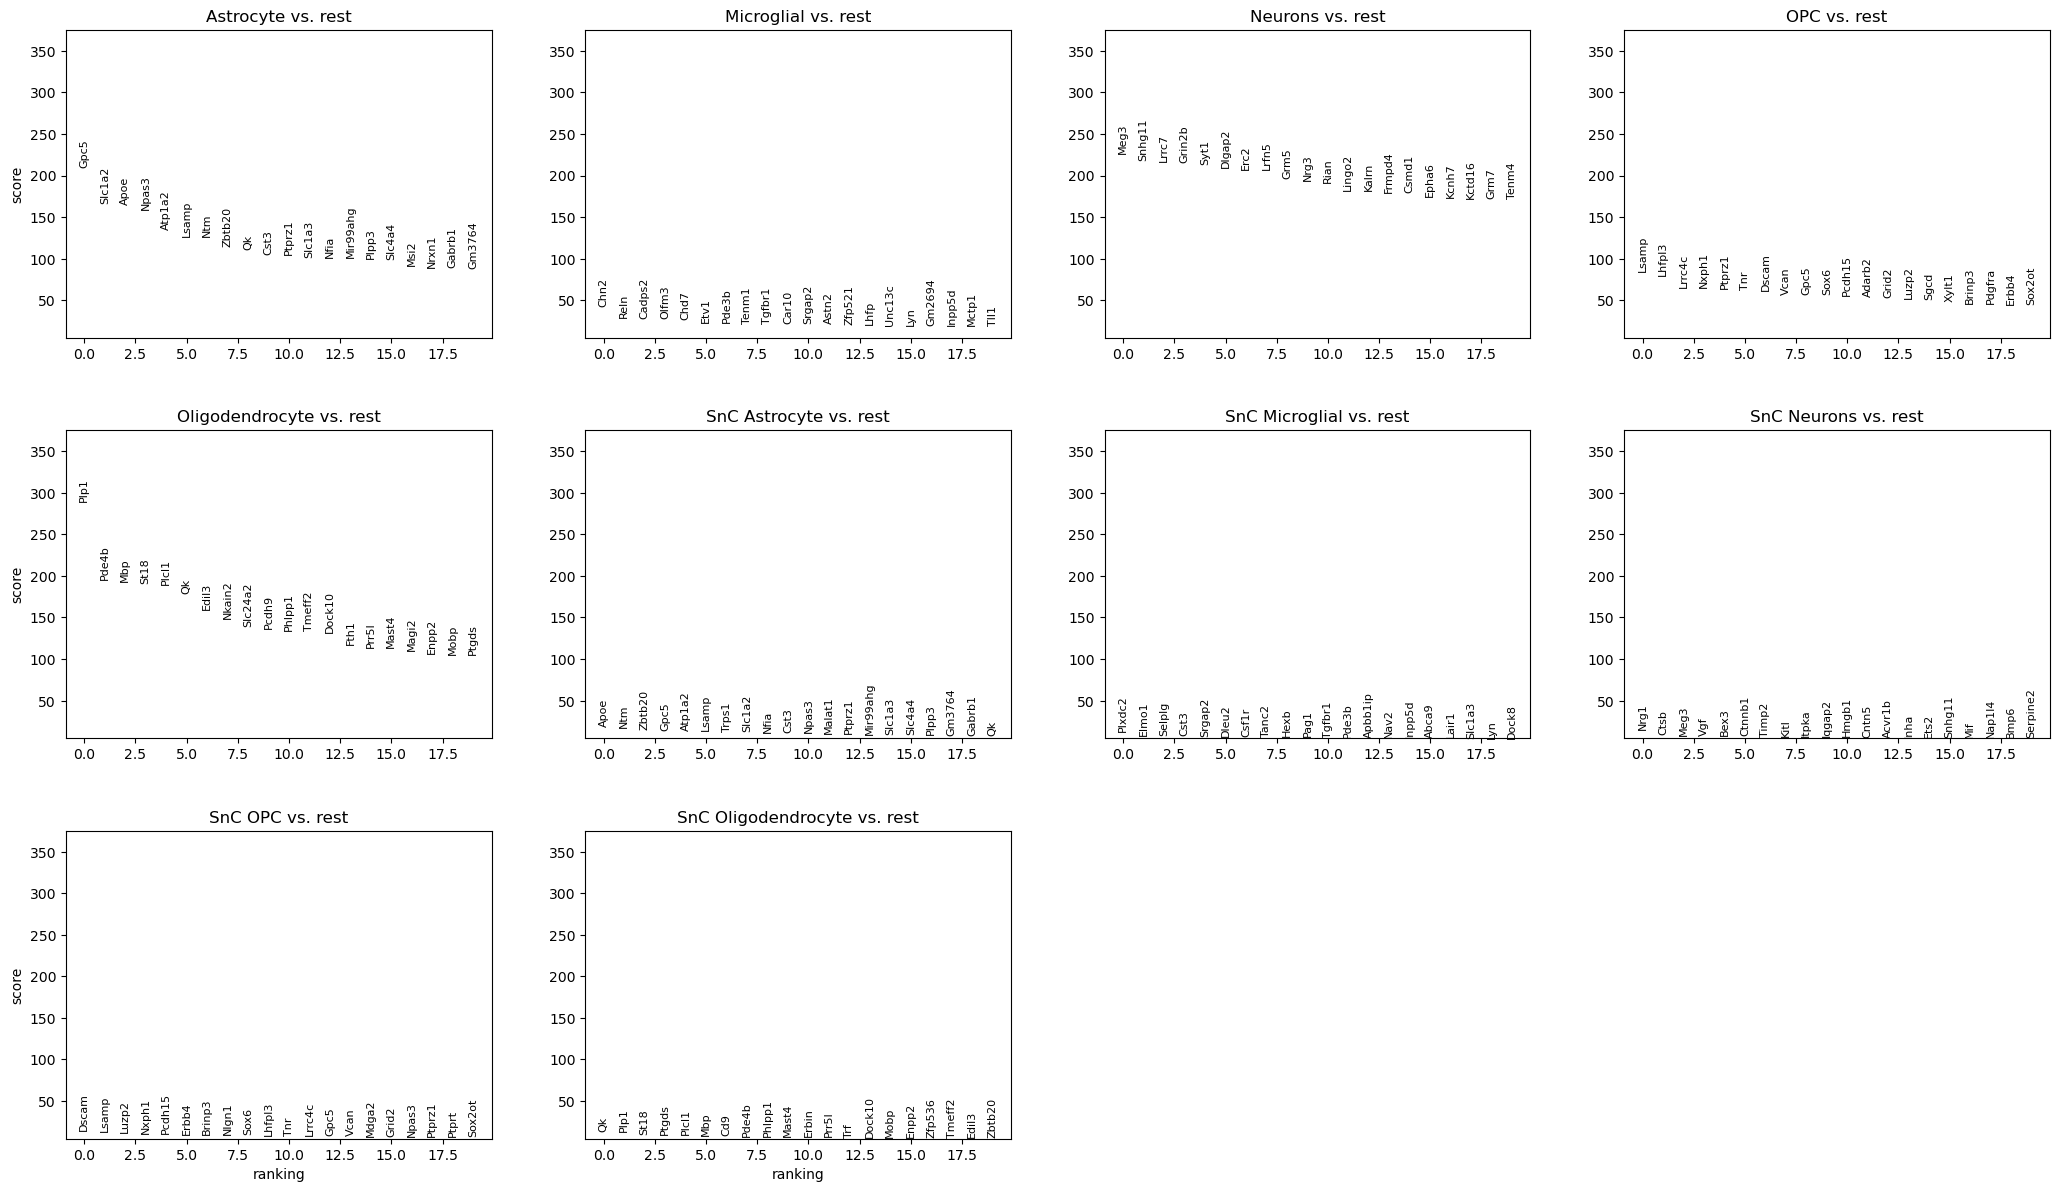

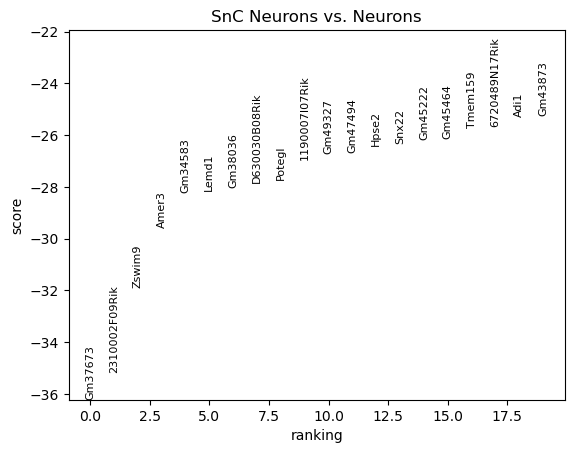

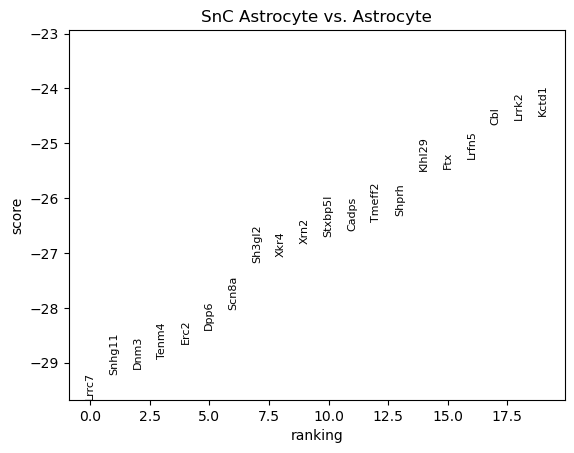

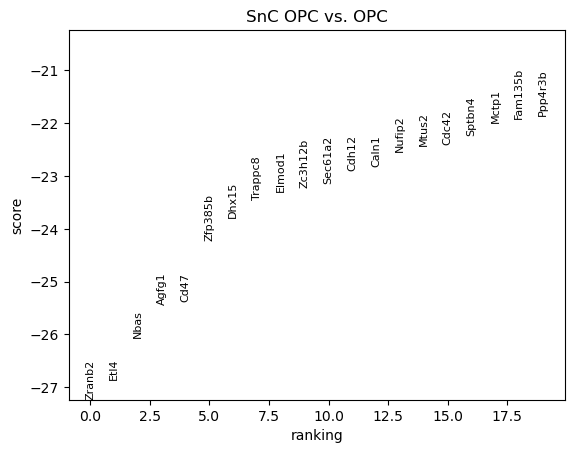

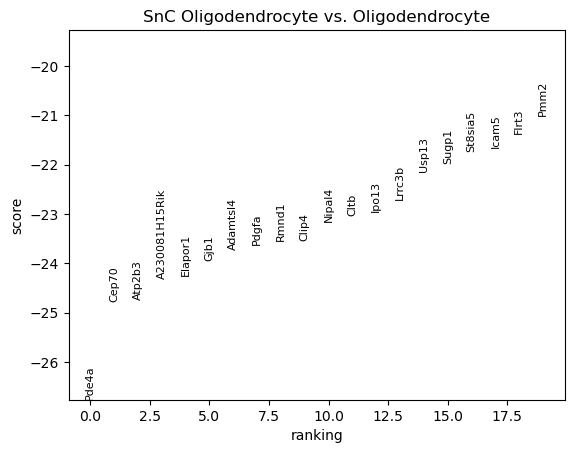

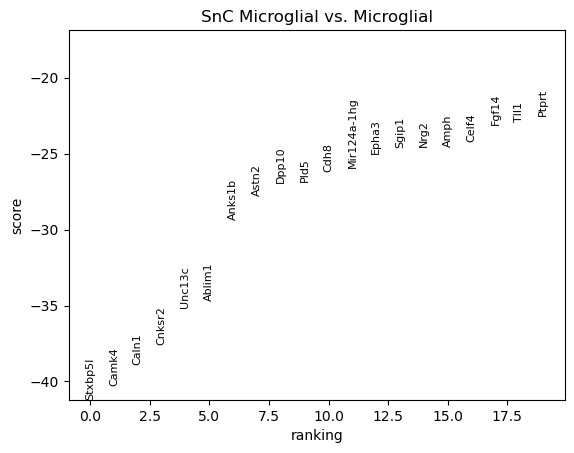

In [11]:
p_threshold = 1e-10
lfc_threshold = 1
self.find_markers(col_celltype="Senescent_Cell_Label_by_Type")
df_snc_markers = {}
df_snc_markers["All"] = self.get_markers_df(
    n_genes=50, col_celltype="Senescent_Cell_Label_by_Type",
    log2fc_threshold=1, p_threshold=1e-10)
# print(df_snc_markers["All"].loc[pd.unique([
#     i[0] for i in df_snc_markers["All"].index.values if (
#         "SnC" in i[0])])].groupby("Senescent_Cell_Label_by_Type").apply(
#             lambda x: x.head(3)))
for x in self.rna.obs[col_celltype].unique():
    df_snc_markers[x] = self.find_markers(
        col_celltype="Senescent_Cell_Label_by_Type",
        reference=x, groups=[x, f"SnC {x}"], rankby_abs=True,
        inplace=False).reset_index(0, drop=True).assign(**{
            col_celltype: f"SnC {x}"}).reset_index().set_index([
                col_celltype, "names"])
df_snc_markers = pd.concat(df_snc_markers, names=["Comparison"])
df_snc_markers = df_snc_markers.rename_axis([
    "Comparison", col_celltype, "names"]).rename({
        "logfoldchanges": "log_fc"}, axis=1).assign(
            log_fc_abs=df_snc_markers["logfoldchanges"].abs())
df_snc_markers_top = df_snc_markers[df_snc_markers.pvals_adj < p_threshold]
df_snc_markers_top = df_snc_markers_top[
    df_snc_markers.log_fc_abs >= lfc_threshold]
df_snc_markers_top = df_snc_markers_top.groupby([
    "Comparison", col_celltype]).apply(
        lambda x: x.assign(scores_abs=x.scores.abs()).sort_values(
            "scores_abs", ascending=False).head(20),
        include_groups=False).reset_index([0, 1], drop=True)

## By Group

In [12]:
res_rank_genes, p_threshold = {}, 1e-10
for x in self.rna.obs[col_batch].unique():
    res_rank_genes[x] = {}
    for c in self.rna.obs[self.rna.obs[col_batch] == x][
            col_celltype].unique():
        s_iter = (self.rna.obs[col_batch] == x) & (self.rna.obs[
            "Senescent_Cell_Label_by_Type"].isin([c, f"SnC {c}"]))
        tmp = sc.tl.rank_genes_groups(
            self.rna[s_iter], "Senescent_Cell_Label_by_Type", rankby_abs=True,
            layer="log1p", groups=[c, f"SnC {c}"], reference=c, copy=True)
        res_rank_genes[x][c] = sc.get.rank_genes_groups_df(
            tmp, f"SnC {c}", pval_cutoff=p_threshold)
    tmp = sc.tl.rank_genes_groups(
            self.rna[self.rna.obs[col_batch] == x],
            "Senescent_Cell_Label", rankby_abs=True,
            layer="log1p", reference="Non-Senescent", copy=True)
    res_rank_genes[x]["Overall"] = sc.get.rank_genes_groups_df(
            tmp, f"Senescent", pval_cutoff=p_threshold)
    res_rank_genes[x] = pd.concat(res_rank_genes[x], names=[col_celltype])
res_rank_genes = pd.concat(res_rank_genes, names=[col_batch])
res_rank_genes = res_rank_genes.assign(
    logfoldchanges_abs=res_rank_genes.logfoldchanges.abs())
res_rank_genes_top = res_rank_genes.reset_index().groupby([
    col_batch, col_celltype]).apply(
        lambda x: x.sort_values("logfoldchanges_abs").iloc[:20],
        include_groups=False).reset_index(2, drop=True).set_index(
            "names", append=True).rename_axis([
                col_batch, col_celltype, "variable"])
res_rank_genes_top

level_2     scores  logfoldchanges         pvals     pvals_adj  logfoldchanges_abs
Condition      annotation_scanvi_collapsed variable                                                                                              
Ground Control Astrocyte                   Cntnap2                1599 -10.192842       -4.176759  4.024139e-12  2.348870e-11            4.176759
                                           C230057M02Rik          3777  -6.860304      -24.383612  8.452166e-12  4.813350e-11           24.383612
                                           A630036G19Rik          3837  -6.780890      -24.392841  1.455707e-11  8.160380e-11           24.392841
                                           Gm44644                3686  -6.967241      -24.404818  4.027217e-12  2.350029e-11           24.404818
                                           Gm37773                3745  -6.900660      -24.460054  6.397495e-12  3.674375e-11           24.460054
                                           Gm50403                3805  -6.821703      -24.463444  1.101670e-11  6.227647e-11           24.463444
                                           Gls2                   3796  -6.829320      -24.486942  1.045664e-11  5.925065e-11           24.486942
                                           8030451O07Rik          3855  -6.763101      -24.493193  1.642911e-11  9.166813e-11           24.493193
                                           ENSMUSG00000120670     3560  -7.110860      -24.512589  1.463304e-12  8.843534e-12           24.512589
                                           Vstm2b                 3694  -6.956823      -24.563202  4.330852e-12  2.521740e-11           24.563202
                                           Gm42919                3381  -7.330920      -24.584299  2.988957e-13  1.902023e-12           24.584299
                                           Cacna1g                3749  -6.895384      -24.594578  6.635293e-12  3.806889e-11           24.594578
                                           Fmnl1                  3852  -6.769104      -24.595642  1.577242e-11  8.807256e-11           24.595642
                                           Gm15414                3682  -6.972372      -24.600147  3.885453e-12  2.270383e-11           24.600147
                                           Gm45177                3319  -7.421389      -24.605246  1.535595e-13  9.954302e-13           24.605246
                                           Gm41361                3458  -7.219649      -24.607628  6.710515e-13  4.175151e-12           24.607628
                                           Hs3st2                 3822  -6.799169      -24.622511  1.285156e-11  7.232575e-11           24.622511
                                           4930547E14Rik          3631  -7.029516      -24.622522  2.602436e-12  1.542039e-11           24.622522
                                           Zcchc12                3790  -6.834270      -24.625839  1.010771e-11  5.736410e-11           24.625839
                                           Ptpru                  3773  -6.863520      -24.635742  8.267100e-12  4.712948e-11           24.635742
               Microglial                  Sphkap                  314 -12.701935       -4.826403  8.439876e-12  9.669006e-11            4.826403
                                           Gpr158                  300 -12.918775       -4.863179  6.512239e-12  7.585859e-11            4.863179
                                           Gabrb2                  278 -13.159273       -4.910023  4.199456e-12  5.005612e-11            4.910023
                                           Scn2a                   241 -13.748945       -5.020534  1.561683e-12  1.955740e-11            5.020534
                                           Sh3gl2                  219 -14.192697       -5.101102  7.790117e-13  1.010273e-11            5.101102
                                           Pclo                    202 -14.528431       -5.163703  4.369092e-13  5.856761

# Plot

## Comparison

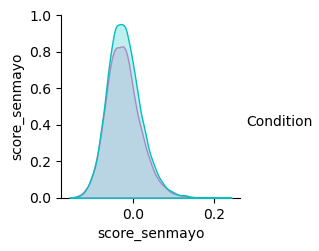

In [13]:
scores = self.rna.obs[[col_batch] + [
    f"score_{x}" for x in sen_metrics]].set_index(
        col_batch, append=True).reset_index()
sns.pairplot(scores, diag_kind="kde", diag_kws=dict(
    cut=0, fill=True, common_norm=True),
             hue=col_batch, palette=palette[col_batch])

## Scores

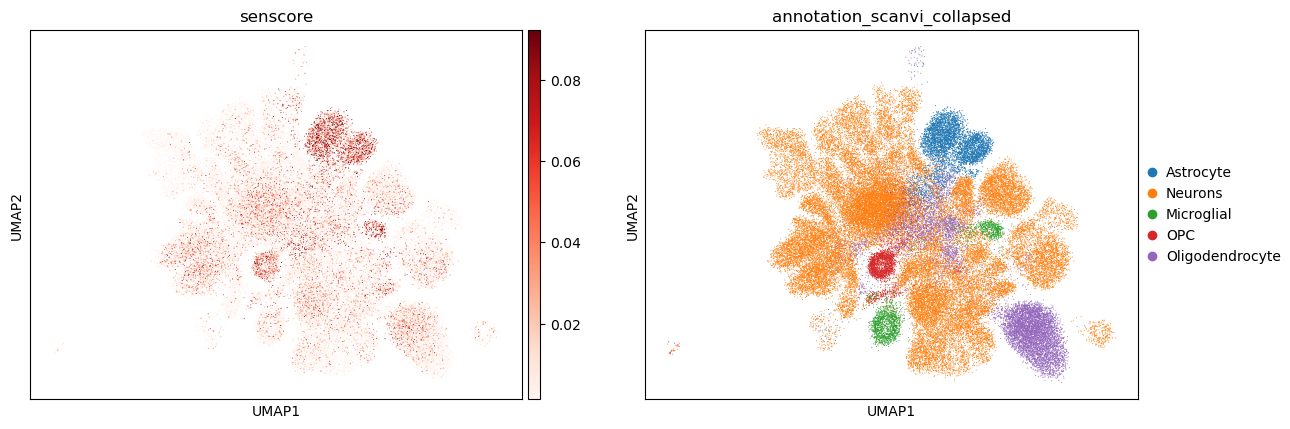

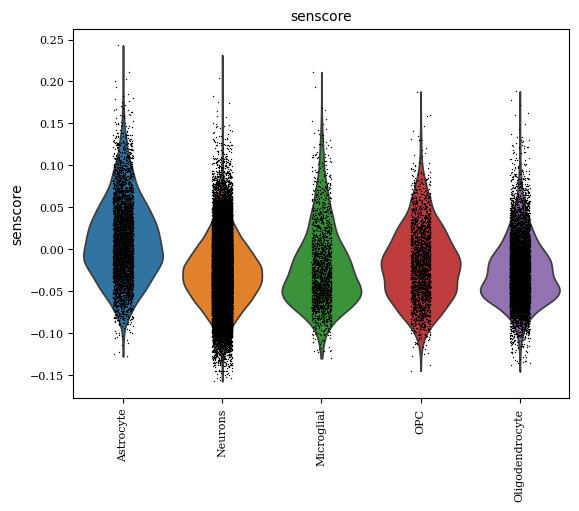

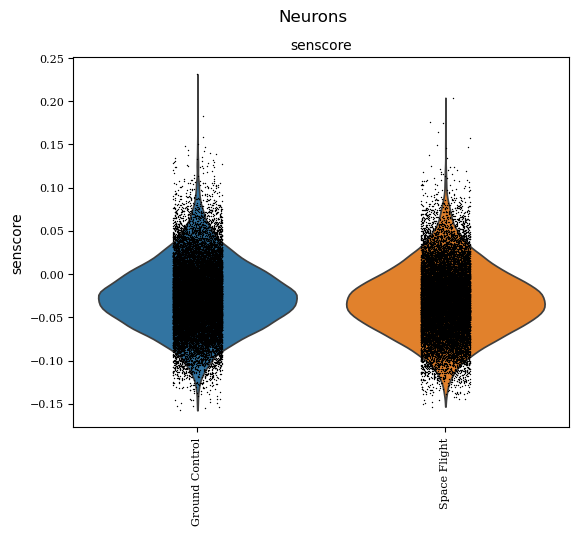

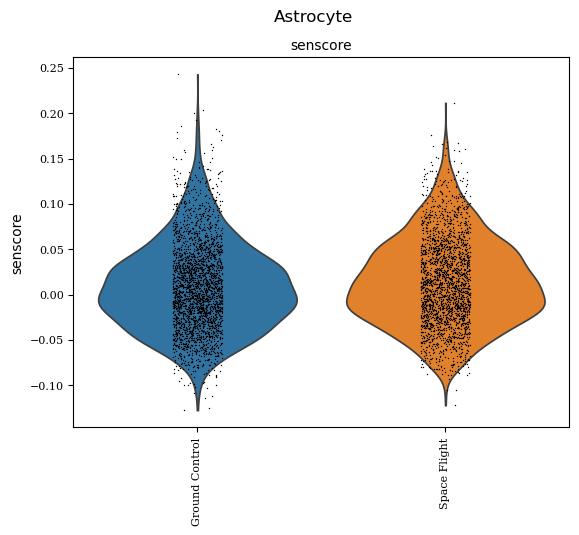

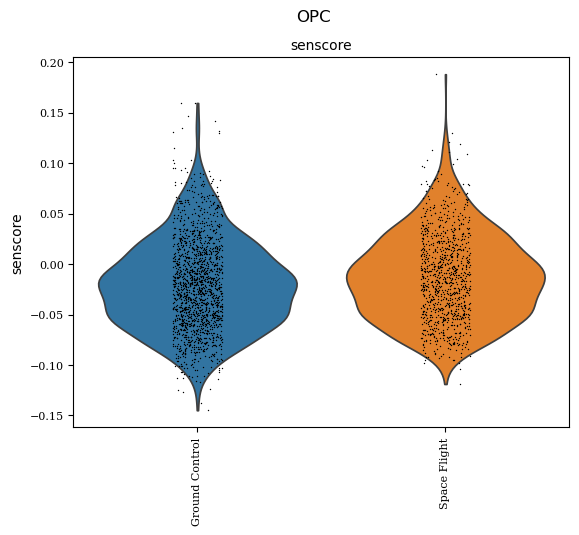

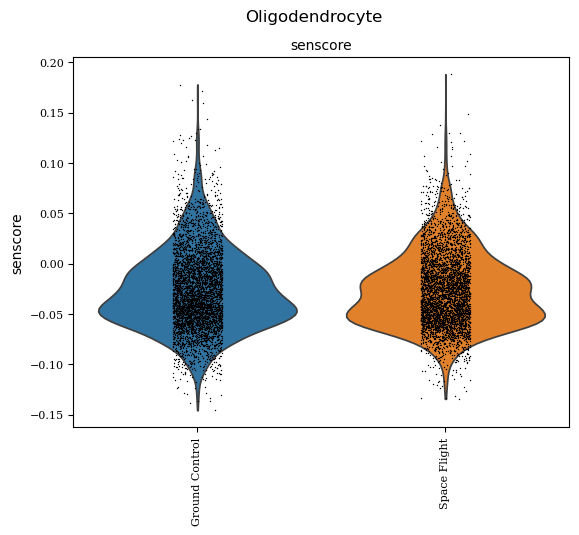

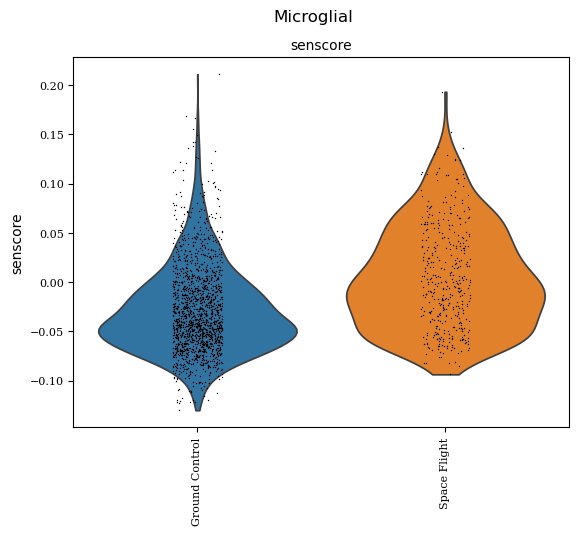

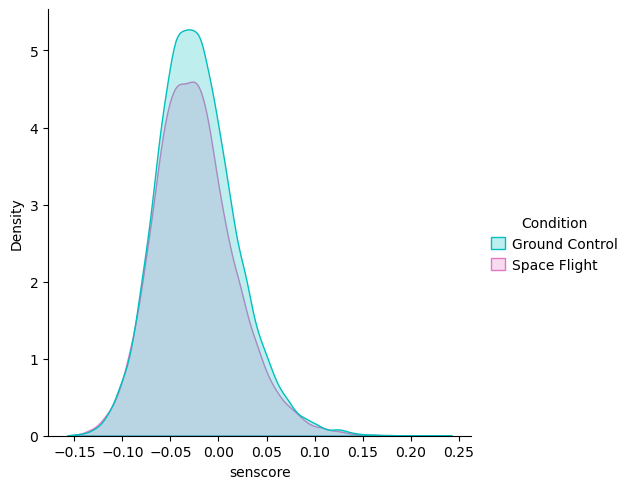

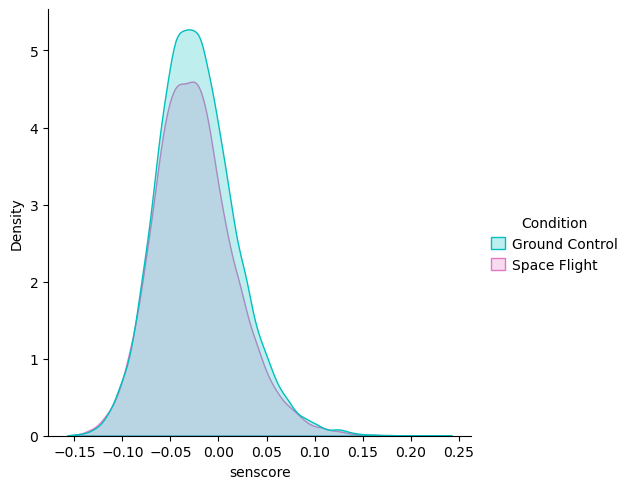

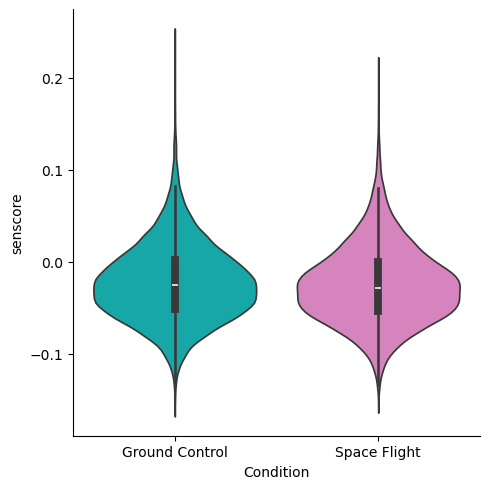

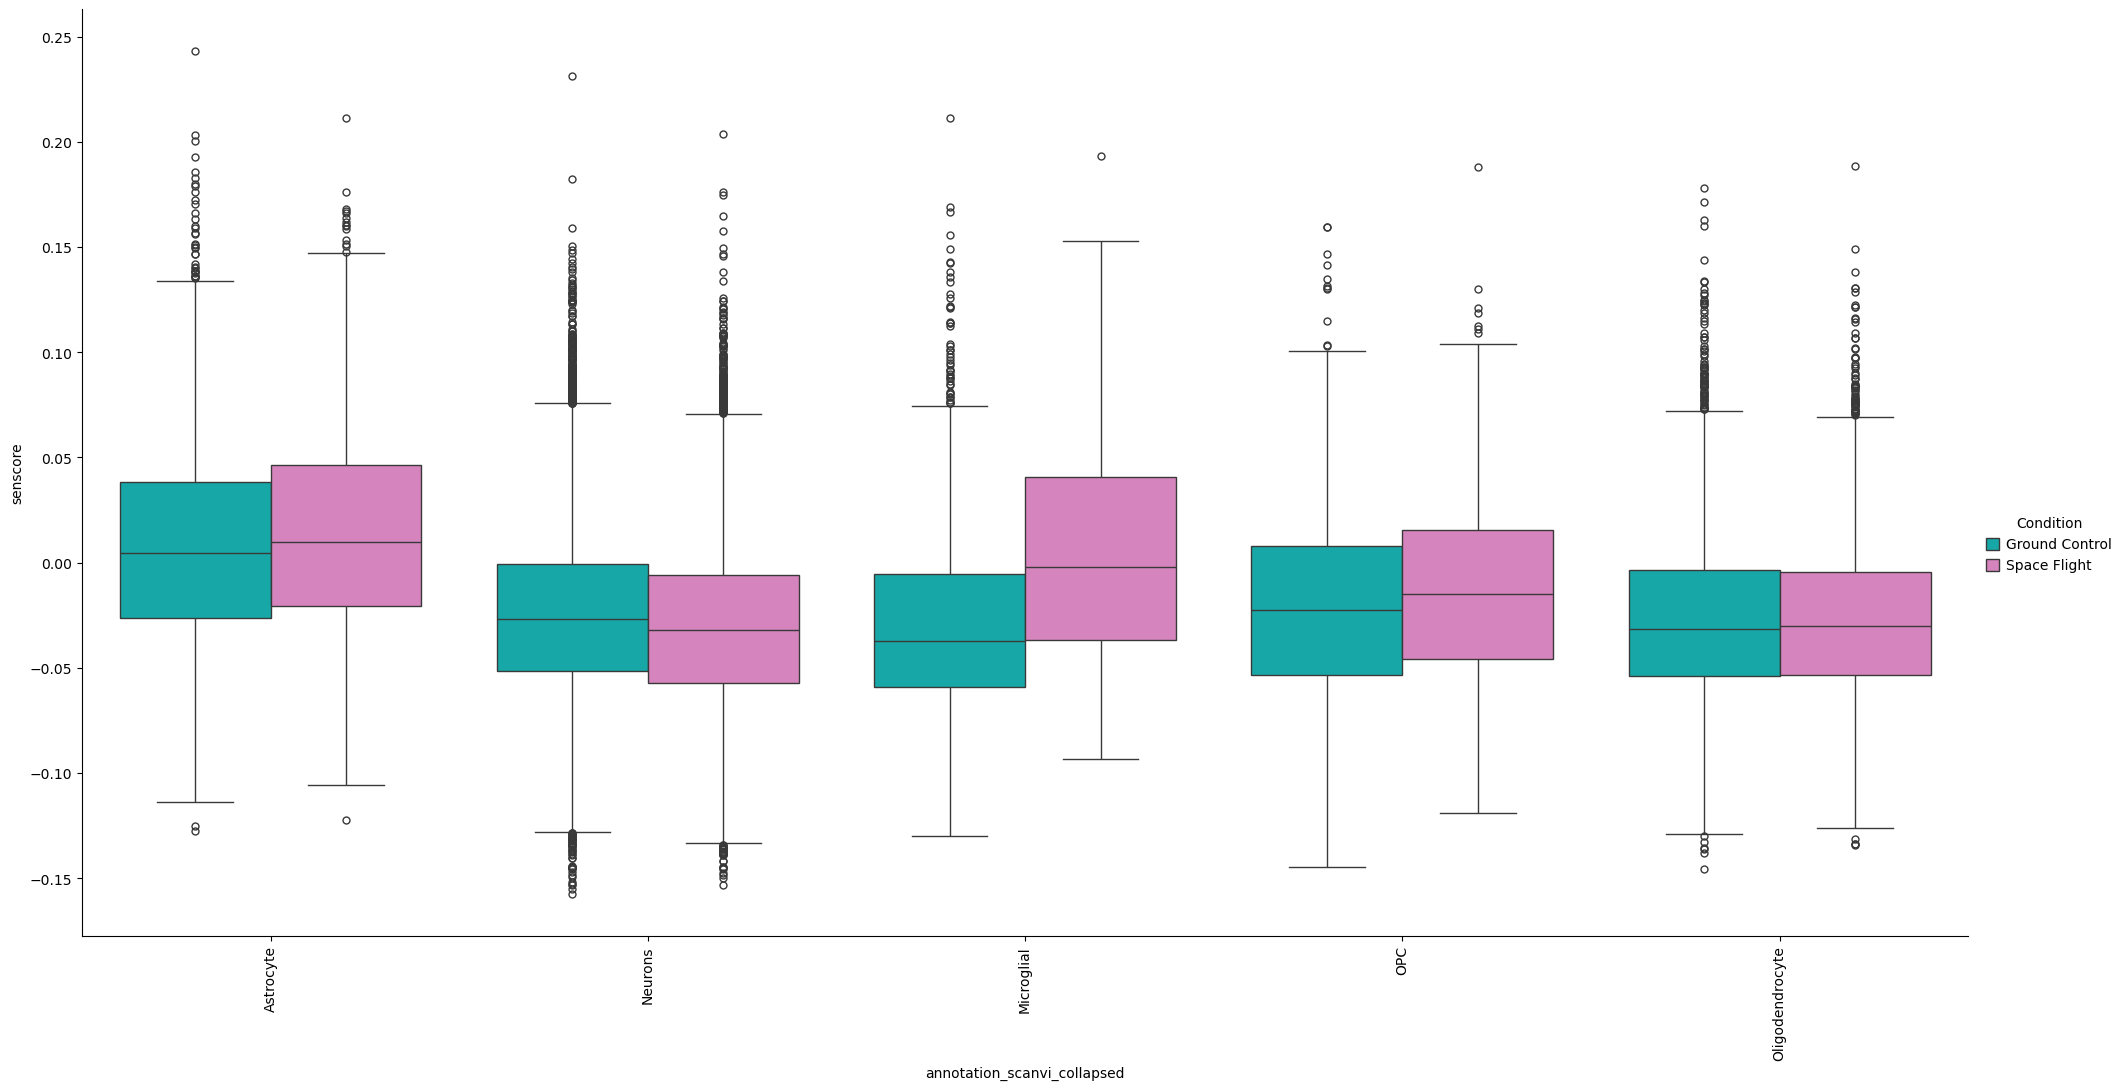

In [15]:
# UMAP with Senescence Scores
bnds = self.rna.obs["senscore"].describe(percentiles=[0.75, 0.99])
_ = self.plot(kind="umap", color=["senscore", col_celltype], umap=dict(
    palette=None, color_map="Reds", vmin=bnds["75%"], vmax=bnds["99%"]))

# Violin Plot of Senescence Scores
_ = self.plot(kind="violin", genes=["senscore"], common_norm=True,
              col_celltype=col_celltype, rotation=90)
_ = self.plot(kind="violin", genes=["senscore"], common_norm=True,
              by_group=col_celltype, col_wrap=1,
              col_celltype=col_batch, rotation=90)

# KDEs
fig_sen_kde = {}
for x in [col_condition, col_batch]:
    fig_sen_kde[x] = sns.displot(self.rna.obs, hue=x, x="senscore",
                                 palette=palette[x], kind="kde",
                                 cut=0, common_norm=True, fill=True)

# Overall (All Cell Types)
fig_sen_overall = sns.catplot(self.rna.obs, x=col_condition,
                              hue=col_condition, y="senscore",
                              palette=palette[col_condition], kind="violin")

# By Cell Type
fig_sen = sns.catplot(self.rna.obs, x=col_celltype, y="senscore",
                      palette=palette[col_batch],
                      hue=col_batch, kind="box", height=10, aspect=2)
for a in fig_sen.axes.flatten():
    a.tick_params(axis="x", labelrotation=90)

## Burden 

Group by sample and cell type and get percentage of senescent cells



                 min  25%  50%  75%   max
Condition                               
Ground Control  0.2  0.6  1.0  1.9  11.1
Space Flight    0.0  0.3  0.8  1.2   7.0


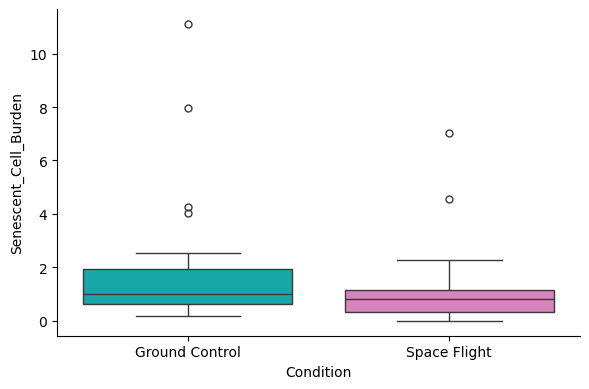

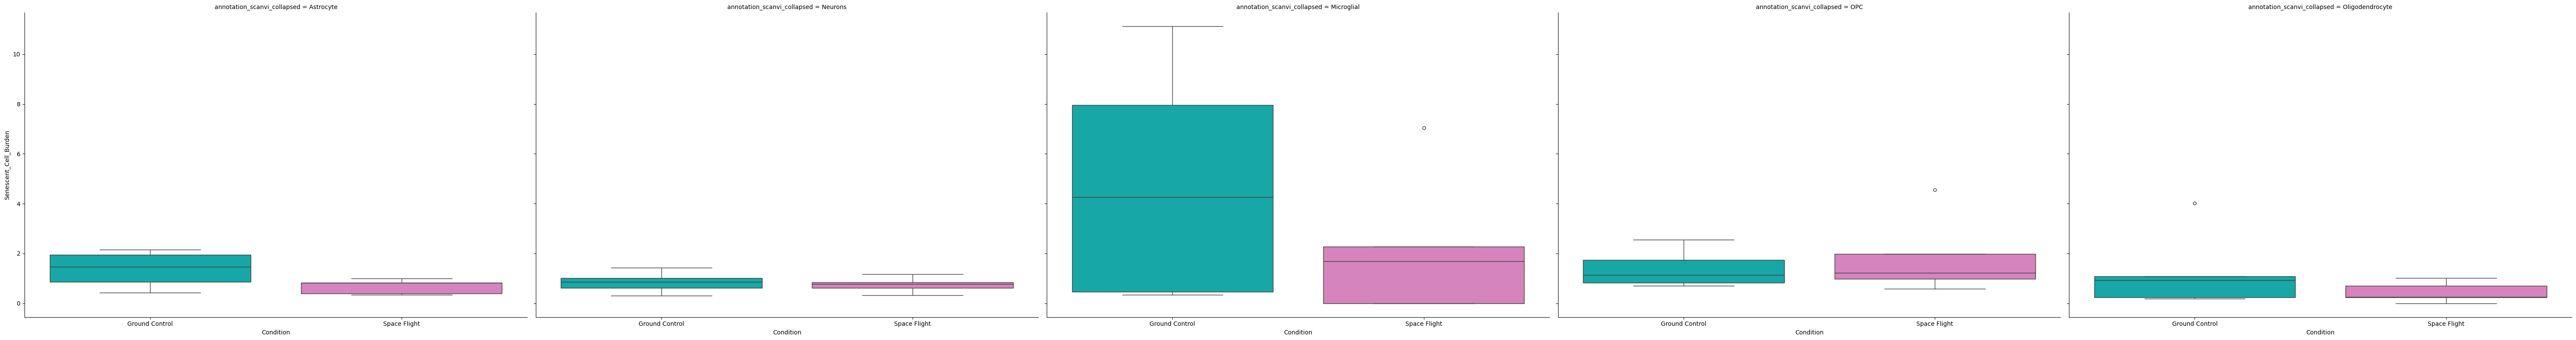

In [20]:
grps = [col_sample, col_celltype, col_batch]
dff = self.rna.obs[grps + ["Senescent_Cell"]].groupby(grps).apply(
    lambda x: x["Senescent_Cell"].mean(), include_groups=False
    ).to_frame("Senescent_Cell_Burden") * 100
# kws_plot = dict(kind="violin", split=False, , common_norm=True)
kws_plot = dict(kind="box", errorbar=("ci", 95))

sns.catplot(y="Senescent_Cell_Burden", x=col_condition, **kws_plot,
            palette=palette[col_condition],
            hue=col_condition, data=dff, height=4, aspect=1.5)
sns.catplot(y="Senescent_Cell_Burden", x=col_condition, **kws_plot,
            col=col_celltype, palette=palette[col_condition],
            hue=col_condition, data=dff, height=8, aspect=1.5)
print("\n\n", round(dff["Senescent_Cell_Burden"].groupby(
    col_condition).describe()[["min", "25%", "50%", "75%", "max"]], 1))

# Analyze

## Regressions & ANOVAs & MEMs

In [22]:
r_dff = polars.DataFrame(dff.reset_index())  # pymer-compatible aggregated df
r_rna = polars.DataFrame(self.rna.obs.rename({
    col_celltype: "CT_"}, axis=1).copy())  # pymer-compatible cell-level df
lvls = ["key_control", "key_treatment"]
factors = {col_condition: [keys[col_condition][i] for i in lvls]}

### Scores

##### Cell Type Random Effects

In [24]:
# Condition (Random Intercept Only)
model_ri = lmer(
    f"senscore ~ {col_condition} + (1 | {col_sample}) + (1 | CT_)",
    data=r_rna)  # set up model
model_ri.set_factors(factors)
model_ri.set_transforms({"senscore": "zscore"})
model_ri.anova(summary=True).show()

# Condition (Condition as Random Effect)
model_re = lmer(
    f"senscore ~ {col_condition} + (1 | {col_sample})"
    f" + (1 + {col_condition} | CT_)",
    data=r_rna)  # set up model
model_re.set_factors(factors)
model_re.set_transforms({"senscore": "zscore"})
model_re.anova(summary=True).show()

# Results
model_ri.summary().show()
model_re.summary().show()
compare(model_ri, model_re).show()

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 61530' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 61530)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 61530' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 61530)' or larger];
but be warned that this may result in large computation time and memory use.



ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Condition 
 1.000 
 inf 
 0.078 
 0.078 
 0.7799 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 61530' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 61530)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 61530' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 61530)' or larger];
but be warned that this may result in large computation time and memory use.



ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Condition 
 1.000 
 inf 
 1.858 
 1.858 
 0.1728 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Condition+(1|sample)+(1|CT_)) 
 
 
 Number of observations: 61530 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -84927 
AIC: 169865 | BIC: 169910 
Residual error: 0.961 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.095 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.378 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.961 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.198 
 0.175 
 −0.266 
 0.661 
 1.132 
 4.524 
 0.3139 
 
 
 
 
 ConditionSpace Flight 
 −0.017 
 0.061 
 −0.157 
 0.123 
 −0.279 
 8.098 
 0.7869 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Condition+(1|sample)+(1+Condition|CT_)) 
 
 
 Number of observations: 61530 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -84758 
AIC: 169530 | BIC: 169593 
Residual error: 0.959 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.092 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.360 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 ConditionSpace Flight 
 0.327 
 
 
 
 
 
 
 
 
 
 CT_-cor 
 (Intercept) 
 −0.103 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.959 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.132 
 0.166 
 −0.309 
 0.573 
 0.793 
 4.530 
 0.4671 
 
 
 
 
 ConditionSpace Flight 
 0.216 
 0.158 
 −0.186 
 0.618 
 1.363 
 5.195 
 0.2289 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Analysis of Deviance Table 
 
 
 Model 1: lmer(senscore~Condition+(1|sample)+(1|CT_)) 
Model 2: lmer(senscore~Condition+(1|sample)+(1+Condition|CT_)) 
 
 
 
 AIC 
 BIC 
 logLik 
 npar 
 -2*log(L) 
 Chisq 
 Df 
 Pr(>Chisq) 
 
 
 
 
 
 1.00 
 169865.4 
 169910.5 
 −84927.7 
 5.00 
 169.85K 
 
 
 
 
 
 
 2.00 
 169530.4 
 169593.6 
 −84758.2 
 7.00 
 169.51K 
 337.15 
 2.00 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

#### Cell Type as Moderator

In [27]:
# Condition + Cell Type
model_cac_mlm_i2 = lmer(
    f"senscore ~  Spaceflight + CT_ + (1 | {col_sample})", data=r_rna)
model_cac_mlm_i2.set_transforms({"senscore": "zscore"})
model_cac_mlm_i2.anova(summary=True).show()

# Condition * Cell Type
model_cac_mlm_i2b = lmer(
    f"senscore ~  Spaceflight * CT_ + (1 | {col_sample})", data=r_rna)
model_cac_mlm_i2b.set_transforms({"senscore": "zscore"})
model_cac_mlm_i2b.anova(summary=True).show()

# GLM Version of Results + Model Comparison
model_cac_mlm_i2.summary().show()
model_cac_mlm_i2b.summary().show()
compare(model_cac_mlm_i2, model_cac_mlm_i2b).show()

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 61530' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 61530)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 61530' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 61530)' or larger];
but be warned that this may result in large computation time and memory use.



ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Spaceflight 
 1.000 
 inf 
 0.078 
 0.078 
 0.7798 
 
 
 
 CT_ 
 4.000 
 inf 
 1,109.382 
 4,437.528 
 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 61530' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 61530)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 61530' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 61530)' or larger];
but be warned that this may result in large computation time and memory use.



ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Spaceflight 
 1.000 
 inf 
 13.188 
 13.188 
 <.001 
 *** 
 
 
 CT_ 
 4.000 
 inf 
 1,164.724 
 4,658.896 
 
 *** 
 
 
 Spaceflight:CT_ 
 4.000 
 inf 
 90.849 
 363.396 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Spaceflight+CT_+(1|sample)) 
 
 
 Number of observations: 61530 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -84925 
AIC: 169866 | BIC: 169938 
Residual error: 0.961 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.095 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.961 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.850 
 0.045 
 0.749 
 0.951 
 18.918 
 9.554 
 <.001 
 *** 
 
 
 
 Spaceflight 
 −0.017 
 0.061 
 −0.157 
 0.123 
 −0.280 
 8.098 
 0.7868 
 
 
 
 
 CT_Neurons 
 −0.931 
 0.014 
 −0.959 
 −0.903 
 −65.750 
 61,519.887 
 
 *** 
 
 
 
 CT_Microglial 
 −0.747 
 0.026 
 −0.797 
 −0.697 
 −29.283 
 61,440.481 
 <.001 
 *** 
 
 
 
 CT_OPC 
 −0.686 
 0.023 
 −0.732 
 −0.641 
 −29.551 
 61,523.782 
 <.001 
 *** 
 
 
 
 CT_Oligodendrocyte 
 −0.896 
 0.017 
 −0.929 
 −0.863 
 −53.974 
 61,519.975 
 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Spaceflight*CT_+(1|sample)) 
 
 
 Number of observations: 61530 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -84753 
AIC: 169531 | BIC: 169639 
Residual error: 0.959 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.092 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.959 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.768 
 0.045 
 0.669 
 0.867 
 17.066 
 11.176 
 <.001 
 *** 
 
 
 
 Spaceflight 
 0.158 
 0.064 
 0.018 
 0.298 
 2.466 
 11.451 
 0.03059 
 * 
 
 
 
 CT_Neurons 
 −0.815 
 0.019 
 −0.852 
 −0.777 
 −42.222 
 61,514.047 
 
 *** 
 
 
 
 CT_Microglial 
 −0.830 
 0.030 
 −0.889 
 −0.770 
 −27.395 
 61,385.828 
 <.001 
 *** 
 
 
 
 CT_OPC 
 −0.695 
 0.030 
 −0.754 
 −0.636 
 −23.123 
 61,514.664 
 <.001 
 *** 
 
 
 
 CT_Oligodendrocyte 
 −0.843 
 0.023 
 −0.888 
 −0.798 
 −36.889 
 61,513.617 
 <.001 
 *** 
 
 
 
 Spaceflight:CT_Neurons 
 −0.249 
 0.028 
 −0.305 
 −0.194 
 −8.813 
 61,516.417 
 <.001 
 *** 
 
 
 
 Spaceflight:CT_Microglial 
 0.616 
 0.060 
 0.498 
 0.733 
 10.281 
 61,515.597 
 <.001 
 *** 
 
 
 
 Spaceflight:CT_OPC 
 0.056 
 0.047 
 −0.037 
 0.149 
 1.182 
 61,519.847 
 0.2373 
 
 
 
 
 Spaceflight:CT_Oligodendrocyte 
 −0.120 
 0.033 
 −0.185 
 −0.055 
 −3.633 
 61,516.485 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Analysis of Deviance Table 
 
 
 Model 1: lmer(senscore~Spaceflight+CT_+(1|sample)) 
Model 2: lmer(senscore~Spaceflight*CT_+(1|sample)) 
 
 
 
 AIC 
 BIC 
 logLik 
 npar 
 -2*log(L) 
 Chisq 
 Df 
 Pr(>Chisq) 
 
 
 
 
 
 1.00 
 169866.2 
 169938.4 
 −84925.1 
 8.00 
 169.82K 
 
 
 
 
 
 
 2.00 
 169531.6 
 169639.9 
 −84753.8 
 12.00 
 169.45K 
 362.50 
 4.00 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

### Binary Snc/Not

Multilevel Logistic Regression

#### Cell Type Random Effects

In [ ]:
glmmod = {}
for x in ["1", f"1 + Spaceflight"]:
    sep = "|" if x == "1" else "||"
    fff = str(f"Senescent_Cell ~ Spaceflight"
              f" + (1 | {col_sample}) + ({x} {sep} CT_)")
    glmmod[x] = glmer(fff, data=r_rna, family="binomial")
    # glmmod[x].set_factors(factors)
    glmmod[x].fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
    # print(glmmod[x].emmeans(col_condition))
    # print(glmmod[x].emmeans(col_age))
    glmmod[x].summary().show()
    # print(glmmod[x].ranef["CT_"])
compare(*[glmmod[x] for x in glmmod])

Formula: glmer(Senescent_Cell~Spaceflight+(1|sample)+(1|CT_)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 61530 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -3101 
AIC: 6210 | BIC: 6246 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.381 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.175 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.010 
 0.006 
 0.015 
 0.002 
 −22.388 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 0.811 
 0.484 
 1.359 
 0.213 
 −0.795 
 inf 
 0.4269 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')



Formula: glmer(Senescent_Cell~Spaceflight+(1|sample)+(1+Spaceflight||CT_)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 61530 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -3099 
AIC: 6208 | BIC: 6253 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.381 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.000 
 
 
 
 
 
 
 
 
 
 CT_.1-sd 
 Spaceflight 
 0.459 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.009 
 0.006 
 0.013 
 0.002 
 −25.845 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 0.989 
 0.505 
 1.937 
 0.339 
 −0.033 
 inf 
 0.9737 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

GT(_tbl_data=shape: (2, 10)
┌─────────────┬─────────────┬──────────────┬──────┬───┬─────┬────────────┬───────┬─────┐
│ AIC         ┆ BIC         ┆ logLik       ┆ npar ┆ … ┆ Df  ┆ Pr(>Chisq) ┆ stars ┆ ids │
│ ---         ┆ ---         ┆ ---          ┆ ---  ┆   ┆ --- ┆ ---        ┆ ---   ┆ --- │
│ f64         ┆ f64         ┆ f64          ┆ i64  ┆   ┆ f64 ┆ str        ┆ str   ┆ i64 │
╞═════════════╪═════════════╪══════════════╪══════╪═══╪═════╪════════════╪═══════╪═════╡
│ 6210.138316 ┆ 6246.247437 ┆ -3101.069158 ┆ 4    ┆ … ┆ 0.0 ┆            ┆       ┆ 1   │
│ 6208.523752 ┆ 6253.660153 ┆ -3099.261876 ┆ 5    ┆ … ┆ 1.0 ┆ 0.0573     ┆ .     ┆ 2   │
└─────────────┴─────────────┴──────────────┴──────┴───┴─────┴────────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x733f48392260>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x733fe3f892e0>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: glmer(Senescent_Cell~Spaceflight+(1|sample)+(1|CT_))   \nModel 2: glmer(Senescent_Cell~Spaceflight+(1|sample)+(1+Spaceflight||CT_))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x733f4891f070>, _formats=[<great_tables._gt_data.FormatInfo object at 0x733f488dd3d0>, <great_tables._gt_data.FormatInfo object at 0x733f488dda90>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x733f488de6f0>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='valu

#### Cell Type as Moderator

In [29]:
# Main Effects
fff = str(f"Senescent_Cell ~  Spaceflight + CT_ + (1 | {col_sample})")
glmmod_ct2b = glmer(fff, data=r_rna, family="binomial")
glmmod_ct2b.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
glmmod_ct2b.anova(summary=True).show()
glmmod_ct2b.summary().show()

# Interaction
fff = str(f"Senescent_Cell ~  Spaceflight * CT_ + (1 | {col_sample})")
model_allix = glmer(fff, data=r_rna, family="binomial")
model_allix.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
model_allix.anova(summary=True).show()
model_allix.summary().show()
res_allix_fixed = pd.DataFrame(model_allix.result_fit[[
    "term", "estimate", "p_value"]], columns=[
        "Term", "OR", "P"]).set_index("Term")
res_allix_fixed.loc[:, "Log-Odds"] = np.log(
    res_allix_fixed.OR.astype(float))
res_allix_fixed.loc[:, "Significance"] = res_allix_fixed.P.apply(
    lambda x: "***" if x < 0.001 else "**" if x < 0.01 else "*" if (
        x < 0.05) else "")
print(res_allix_fixed)

# Model Comparison
compare(glmmod_ct2b, model_allix)

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Spaceflight 
 1.000 
 inf 
 0.511 
 0.511 
 0.4748 
 
 
 
 CT_ 
 4.000 
 inf 
 2.988 
 11.952 
 0.0177 
 * 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: glmer(Senescent_Cell~Spaceflight+CT_+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 61530 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -3096 
AIC: 6206 | BIC: 6269 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.382 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.009 
 0.006 
 0.014 
 0.002 
 −20.161 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 0.827 
 0.491 
 1.393 
 0.220 
 −0.715 
 inf 
 0.4748 
 
 
 
 
 CT_Neurons 
 0.979 
 0.719 
 1.334 
 0.154 
 −0.134 
 inf 
 0.8931 
 
 
 
 
 CT_Microglial 
 1.787 
 1.089 
 2.931 
 0.451 
 2.299 
 inf 
 0.02152 
 * 
 
 
 
 CT_OPC 
 1.341 
 0.842 
 2.137 
 0.319 
 1.236 
 inf 
 0.2165 
 
 
 
 
 CT_Oligodendrocyte 
 0.870 
 0.601 
 1.259 
 0.164 
 −0.739 
 inf 
 0.4601 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Spaceflight 
 1.000 
 inf 
 0.002 
 0.002 
 0.9689 
 
 
 
 CT_ 
 4.000 
 inf 
 4.877 
 19.508 
 <.001 
 *** 
 
 
 Spaceflight:CT_ 
 4.000 
 inf 
 2.159 
 8.636 
 0.07087 
 . 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: glmer(Senescent_Cell~Spaceflight*CT_+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 61530 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -3092 
AIC: 6206 | BIC: 6305 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.374 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.009 
 0.005 
 0.015 
 0.002 
 −18.643 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 0.825 
 0.389 
 1.750 
 0.317 
 −0.501 
 inf 
 0.6167 
 
 
 
 
 CT_Neurons 
 0.995 
 0.673 
 1.470 
 0.198 
 −0.027 
 inf 
 0.9787 
 
 
 
 
 CT_Microglial 
 1.353 
 0.730 
 2.510 
 0.426 
 0.960 
 inf 
 0.337 
 
 
 
 
 CT_OPC 
 1.118 
 0.611 
 2.047 
 0.345 
 0.361 
 inf 
 0.7181 
 
 
 
 
 CT_Oligodendrocyte 
 0.991 
 0.624 
 1.575 
 0.234 
 −0.038 
 inf 
 0.97 
 
 
 
 
 Spaceflight:CT_Neurons 
 0.958 
 0.512 
 1.791 
 0.306 
 −0.134 
 inf 
 0.8931 
 
 
 
 
 Spaceflight:CT_Microglial 
 2.547 
 0.935 
 6.944 
 1.303 
 1.828 
 inf 
 0.06761 
 . 
 
 
 
 Spaceflight:CT_OPC 
 1.573 
 0.620 
 3.994 
 0.748 
 0.953 
 inf 
 0.3404 
 
 
 
 
 Spaceflight:CT_Oligodendrocyte 
 0.718 
 0.339 
 1.520 
 0.275 
 −0.866 
 inf 
 0.3864 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

                                      OR         P  Log-Odds Significance
Term                                                                     
(Intercept)                     0.008896       0.0 -4.722126          ***
Spaceflight                     0.825294  0.616666 -0.192016             
CT_Neurons                      0.994684  0.978662 -0.005330             
CT_Microglial                    1.35331  0.337003  0.302553             
CT_OPC                          1.117811  0.718139  0.111373             
CT_Oligodendrocyte              0.991147  0.969967 -0.008893             
Spaceflight:CT_Neurons           0.95801  0.893143 -0.042897             
Spaceflight:CT_Microglial       2.547398  0.067606  0.935073             
Spaceflight:CT_OPC              1.573386  0.340353  0.453230             
Spaceflight:CT_Oligodendrocyte  0.717781  0.386426 -0.331591             


GT(_tbl_data=shape: (2, 10)
┌─────────────┬─────────────┬──────────────┬──────┬───┬─────┬────────────┬───────┬─────┐
│ AIC         ┆ BIC         ┆ logLik       ┆ npar ┆ … ┆ Df  ┆ Pr(>Chisq) ┆ stars ┆ ids │
│ ---         ┆ ---         ┆ ---          ┆ ---  ┆   ┆ --- ┆ ---        ┆ ---   ┆ --- │
│ f64         ┆ f64         ┆ f64          ┆ i64  ┆   ┆ f64 ┆ str        ┆ str   ┆ i64 │
╞═════════════╪═════════════╪══════════════╪══════╪═══╪═════╪════════════╪═══════╪═════╡
│ 6206.28913  ┆ 6269.480091 ┆ -3096.144565 ┆ 7    ┆ … ┆ 0.0 ┆            ┆       ┆ 1   │
│ 6206.169832 ┆ 6305.469914 ┆ -3092.084916 ┆ 11   ┆ … ┆ 4.0 ┆ 0.0873     ┆ .     ┆ 2   │
└─────────────┴─────────────┴──────────────┴──────┴───┴─────┴────────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x733f48acf8e0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x733f48ac1af0>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: glmer(Senescent_Cell~Spaceflight+CT_+(1|sample))   \nModel 2: glmer(Senescent_Cell~Spaceflight*CT_+(1|sample))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x733fe3e4da50>, _formats=[<great_tables._gt_data.FormatInfo object at 0x733f48ac1490>, <great_tables._gt_data.FormatInfo object at 0x733f48ac38f0>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x733f48ac0170>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'),

### Just Age as Predictor

In [ ]:
# model_cac_mlm_i3_a = lmer(
#     f"senscore ~  {col_age} * {col_celltype} + (1 | {col_sample})",
#     data=r_rna)  # set up model
# model_cac_mlm_i3_a.set_factors(factors)
# model_cac_mlm_i3_a.set_transforms({"senscore": "zscore"})
# model_cac_mlm_i3_a.fit()
# model_cac_mlm_i3_a.summary().show()

# fff = str(f"Senescent_Cell ~ Aged * {col_celltype} + "
#           "(1 | sample)")
# glmmod_ct2a = glmer(fff, data=r_rna, family="binomial")
# glmmod_ct2a.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
# glmmod_ct2a.summary().show()

### Lower SnC Threshold

In [30]:
# Column for Lower Threshold Classification
chp = f"Senescent_Cell_{use_metric}_{p_h}"  # column name

# Cell Type Random Effects
fff = str(f"{chp} ~ Spaceflight"
          f" + (1 | {col_sample}) + (1 + Spaceflight || CT_)")
glmmod_lenient_thresh = glmer(fff, data=r_rna, family="binomial")
glmmod_lenient_thresh.fit(exponentiate=True, ncpus=ncpus)  # => odds
glmmod_lenient_thresh.summary().show()

# Cell Type as Moderator
fff = str(f"{chp} ~ Spaceflight * CT_ + (1 | {col_sample})")
glmmod_lenient_thresh_ct = glmer(fff, data=r_rna, family="binomial")
glmmod_lenient_thresh_ct.fit(exponentiate=True, ncpus=ncpus)  # => odds
glmmod_lenient_thresh_ct.summary().show()

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')



Formula: glmer(Senescent_Cell_senmayo_3~Spaceflight+(1|sample)+(1+Spaceflight||CT_)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 61530 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -7764 
AIC: 15538 | BIC: 15583 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.265 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.000 
 
 
 
 
 
 
 
 
 
 CT_.1-sd 
 Spaceflight 
 0.624 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.030 
 0.024 
 0.038 
 0.004 
 −28.499 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 1.263 
 0.664 
 2.403 
 0.414 
 0.713 
 inf 
 0.476 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: glmer(Senescent_Cell_senmayo_3~Spaceflight*CT_+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 61530 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -7753 
AIC: 15528 | BIC: 15627 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.255 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.030 
 0.022 
 0.041 
 0.005 
 −21.840 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 1.004 
 0.634 
 1.589 
 0.235 
 0.017 
 inf 
 0.9862 
 
 
 
 
 CT_Neurons 
 0.989 
 0.785 
 1.247 
 0.117 
 −0.090 
 inf 
 0.9284 
 
 
 
 
 CT_Microglial 
 1.159 
 0.808 
 1.662 
 0.213 
 0.802 
 inf 
 0.4226 
 
 
 
 
 CT_OPC 
 1.044 
 0.729 
 1.494 
 0.191 
 0.234 
 inf 
 0.8147 
 
 
 
 
 CT_Oligodendrocyte 
 0.995 
 0.755 
 1.312 
 0.140 
 −0.034 
 inf 
 0.973 
 
 
 
 
 Spaceflight:CT_Neurons 
 0.763 
 0.537 
 1.082 
 0.136 
 −1.518 
 inf 
 0.129 
 
 
 
 
 Spaceflight:CT_Microglial 
 3.710 
 2.160 
 6.372 
 1.024 
 4.750 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight:CT_OPC 
 1.280 
 0.741 
 2.208 
 0.356 
 0.886 
 inf 
 0.3759 
 
 
 
 
 Spaceflight:CT_Oligodendrocyte 
 0.805 
 0.532 
 1.219 
 0.170 
 −1.023 
 inf 
 0.3064 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

## Perturbation Distance

Output()



Overall Distance




Output()

Output()

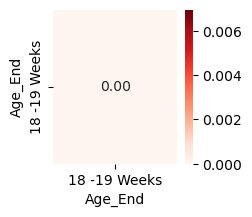

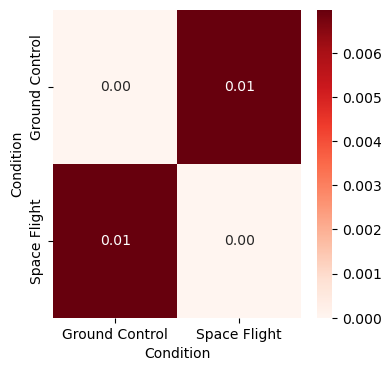

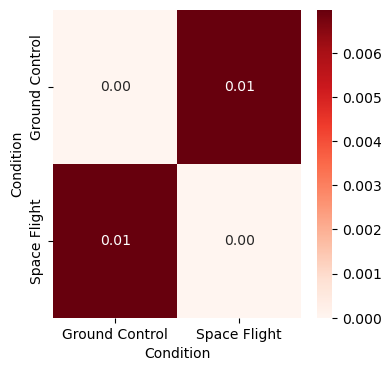



Just Senescence Genes




Output()

Output()

Output()

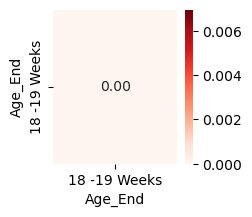

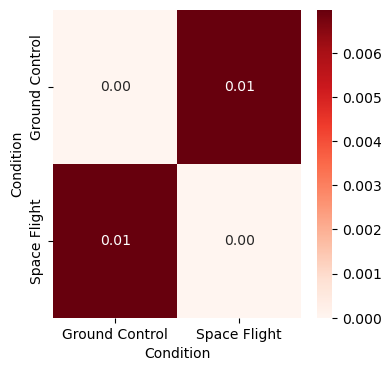

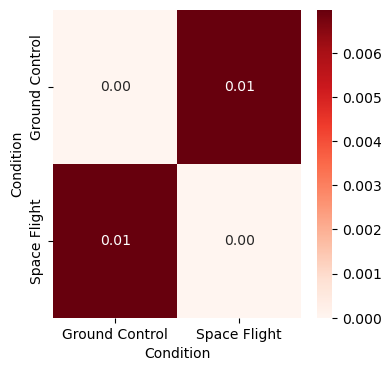

In [31]:
print(f"\n\n{'=' * 80}\nOverall Distance\n{'=' * 80}\n\n")
df_distance, figs_distance = scflow.ax.analyze_perturbation_distance(
    self.rna, col_condition=[col_age, col_condition, col_batch])

print(f"\n\n{'=' * 80}\nJust Senescence Genes\n{'=' * 80}\n\n")
df_distance_snc, figs_distance_snc = scflow.ax.analyze_perturbation_distance(
    self.rna[:, genes], col_condition=[
        col_age, col_condition, col_batch])

## Composition Analysis

### Cell Type

In [ ]:
# print(f"\n\n{'=' * 80}\nOverall Sample\n{'=' * 80}\n\n")
# out_ctc = scflow.ax.analyze_composition(
#     self.rna, col_celltype, col_batch, col_sample=col_sample,
#     palette=palette[col_batch],
#     formula=None, key_modality="coda", reference_cell_type="automatic",
#     absence_threshold=0.1, est_fdr=0.1, level_order=[keys[
#         col_batch]["key_control"]] + keys[col_batch]["key_treatment"])
# plt.show()

# print(f"\n\n{'=' * 80}\nAged Subset\n{'=' * 80}\n\n")
# out_ctc_sf = scflow.ax.analyze_composition(
#     self.rna[self.rna.obs[col_age] != keys[col_age]["key_control"]],
#     col_celltype, col_condition, col_sample=col_sample,
#     formula=None, key_modality="coda", reference_cell_type="automatic",
#     absence_threshold=0.1, est_fdr=0.1, level_order=[keys[col_condition][
#         "key_control"]] + [keys[col_condition]["key_treatment"]])

### Senescent Cells

#### Tree-Aggregated

• Zero counts encountered in data! Added a pseudocount of 0.5.


INFO:2025-09-02 11:16:09,281:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-09-02 11:16:09 | [INFO] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
sample: 100%|█| 12000/12000 [01:13<00:00, 163.60it/s, 15 steps of size 2.63e-01
2025-09-02 11:17:33 | [INFO] arviz_base not installed
2025-09-02 11:17:33 | [INFO] arviz_stats not installed
2025-09-02 11:17:33 | [INFO] arviz_plots not installed


                                          Compositional Analysis summary                                           
┌──────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────┐
│ Name                             │ Value                                                                        │
├──────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────┤
│ Data                             │ Data: 10 samples, 10 cell types                                              │
│ Reference cell type              │ Neurons                                                                      │
│ Formula                          │ Condition                                                                    │
│ Reference index                  │ [2, 0]                                                                       │
│ MCMC Sampling                    │ Sampled 10000 chain states (2000 burnin samples)                             │
│ Acceptance rate                  │ 86.1%                                                                        │
└──────────────────────────────────┴──────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Astrocyte                          2.409        2.019   2.777  0.202      528.117                               │
│ Microglial                         0.995        0.498   1.442  0.252      128.421                               │
│ Neurons                            4.495        4.154   4.849  0.184     4252.735                               │
│ OPC                                1.656        1.237   2.079  0.224      248.717                               │
│ Oligodendrocyte                    2.920        2.550   3.287  0.195      880.348                               │
│ SnC Astrocyte                     -0.950       -1.598  -0.366  0.329       18.363                               │
│ SnC Microglial                    -1.169       -1.777  -0.547  0.332       14.751                               │
│ SnC Neurons                       -0.006       -0.565   0.516  0.289       47.196                               │
│ SnC OPC                           -1.086       -1.694  -0.466  0.328       16.028                               │
│ SnC Oligodendrocyte               -0.944       -1.576  -0.366  0.327       18.473                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     Effect  Expected Sample  log2-fold change                                   │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Astrocyte            0.000       528.117           0.000                                         │
│                Microglial           0.000       128.421           0.000                                         │
│                Neurons              0.000      4252.735           0.000                                         │
│                OPC                  0.000       248.717           0.000                                         │
│                Oligodendrocyte      0.000       880.348           0.000                                         │
│                SnC Astrocyte        0.000        18.363           0.000                                         │
│                SnC Microglial       0.000        14.751           0.000                                         │
│                SnC Neurons          0.000        47.196           0.000                                         │
│                SnC OPC              0.000        16.028           0.000                                         │
│                SnC Oligodendrocyte  0.000        18.473           0.000                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     Median  HDI 3%  HDI 97%   SD                                                │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Astrocyte            0.050   -0.084  0.241   0.083                                               │
│                Microglial           0.032   -0.236  0.207   0.115                                               │
│                Neurons              0.000    0.000  0.000   0.000                                               │
│                OPC                  0.028   -0.198  0.227   0.108                                               │
│                Oligodendrocyte      0.068   -0.055  0.269   0.085                                               │
│                SnC Astrocyte        0.069   -0.230  0.368   0.154                                               │
│                SnC Microglial       0.070   -0.223  0.380   0.155                                               │
│                SnC Neurons          0.072   -0.226  0.375   0.154                                               │
│                SnC OPC              0.071   -0.229  0.365   0.155                                               │
│                SnC Oligodendrocyte  0.070   -0.228  0.364   0.154                                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Nodes                                                                                                           │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Covariate=Condition[T.Space Flight]_node                                                                        │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                      Final Parameter  Median  HDI 3%  HDI 97%  SD   Delta  Is credible                          │
│ Node                                                                                                            │
│ Non-Senescent             0.00         0.00    0.00    0.00   0.00  0.00      False                             │
│ Senescent                 0.00         0.03   -0.18    0.20   0.10  0.12      False                             │
│ Neurons                   0.00         0.00    0.00    0.00   0.00  0.00      False                             │
│ Astrocyte                 0.00         0.05   -0.08    0.24   0.08  0.12      False                             │
│ OPC                       0.00         0.03   -0.20    0.23   0.11  0.12      False                             │
│ Oligodendrocyte           0.00         0.07   -0.06    0.27   0.09  0.12      False                             │
│ Microglial                0.00         0.03   -0.24    0.21   0.12  0.12      False                             │
│ SnC Oligodendrocyte       0.00         0.04   -0.17    0.27   0.11  0.12      False                             │
│ SnC Astrocyte             0.00         0.04   -0.17    0.26   0.11  0.12      False                             │
│ SnC Neurons               0.00         0.04   -0.17    0.26   0.11  0.12      False                             │
│ SnC Microglial            0.00         0.04   -0.17    0.26   0.11  0.12      False                             │
│ SnC OPC                   0.00         0.04   -0.16    0.28   0.11  0.12      False                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

Wrote file: /home/easlinger/AWG/ADBR/Brain_AWG/Senescence/tree_effect.png


<Figure size 0x300 with 0 Axes>

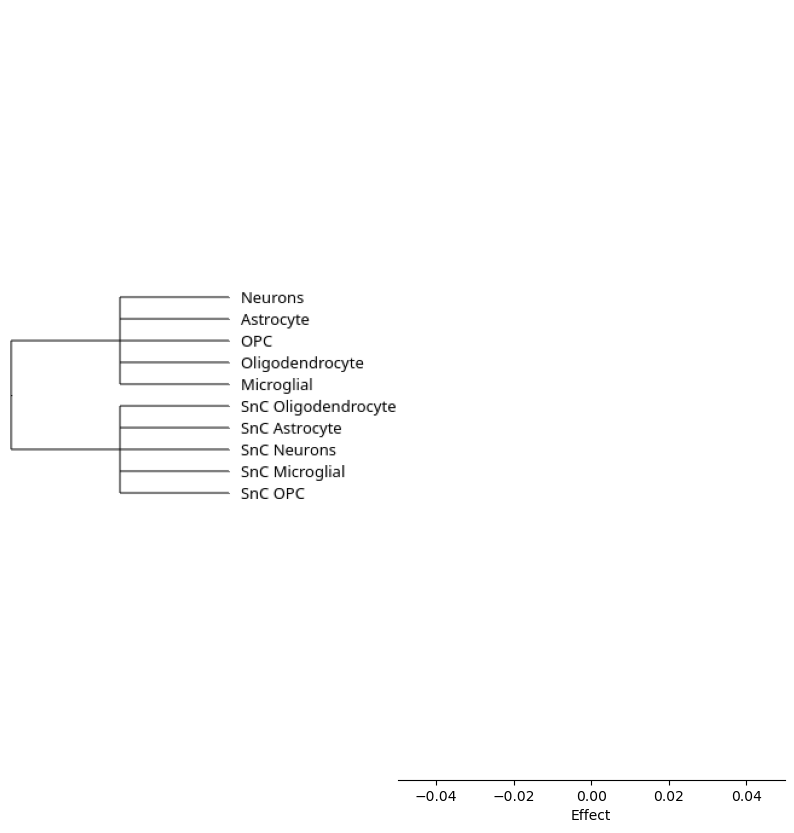

In [37]:
# Setup
# col_celltype_hierarchy = [
#     f"{col_celltype}_hierarchical", "SnC_hierarchy"]
# col_celltype_hierarchy = [
#     "Senescent_Cell", f"{col_celltype}_hierarchical", "SnC_hierarchy",
#     "Senescent_Cell_Label_by_Type"]
# col_celltype_hierarchy = [
#     "Senescent_Cell_Label", f"SnC_hierarchy",
#     "Senescent_Cell_Label_by_Type"]
col_celltype_hierarchy = [
    "Senescent_Cell_Label", "Senescent_Cell_Label_by_Type"]
ref_celltype = self.rna.obs[col_celltype_hierarchy[-1]].value_counts(
    ).index.values[0]
form_c = " + ".join([col_condition, col_age]) + " + " + " * ".join([
    col_condition, col_age])

# By SF vs. GC (No Age)
_ = scflow.ax.analyze_composition_tree(
    self.rna, col_celltype_hierarchy[-1], col_condition,
    col_sample=col_sample, formula=None, seed=0, est_fdr=0.2,
    reference_cell_type=ref_celltype, num_warmup=2000,
    col_celltype_hierarchy=col_celltype_hierarchy)

#### `scCoda`

##### Higher SnC Threshold

Seed = 0; 10000 samples; 10000 warmup


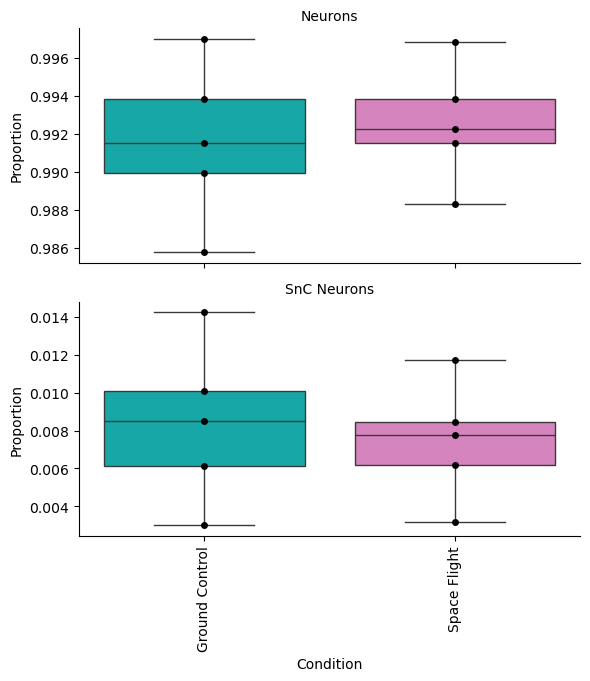

sample: 100%|█| 12000/12000 [01:12<00:00, 165.73it/s, 15 steps of size 1.70e-01


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 10 samples, 2 cell types                                          │
│ Reference cell type                   │ Neurons                                                                 │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 77.6%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Neurons                           6.248        5.116   7.281   0.576     4177.776                               │
│ SnC Neurons                       1.455        0.405   2.468   0.550       34.624                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                             Final Parameter  Expected Sample  log2-fold change                                  │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Neurons          0.000           4177.776           0.000                                        │
│                SnC Neurons      0.000             34.624           0.000                                        │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                             HDI 3%  HDI 97%   SD   Inclusion probability                                        │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Neurons       0.000  0.000   0.000         0.000                                                 │
│                SnC Neurons  -0.517  0.382   0.138         0.355                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate   Condition[T.Space Flight]
Cell Type                            
Neurons                              
SnC Neurons                          




Seed = 0; 10000 samples; 10000 warmup


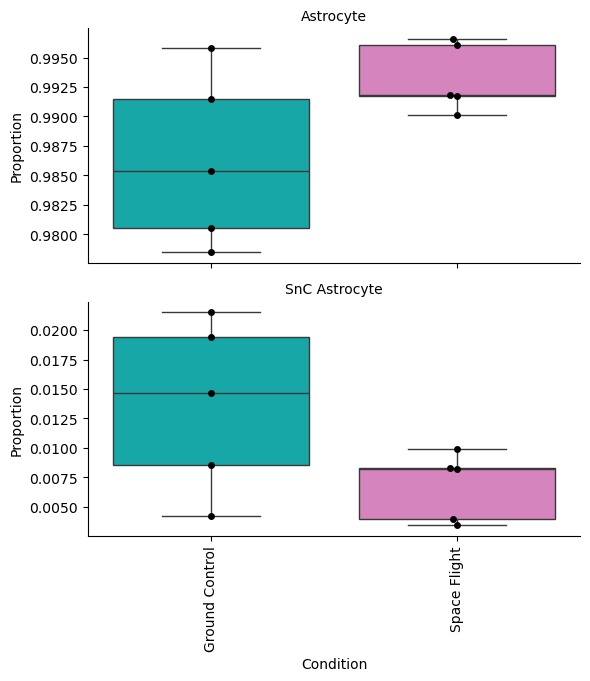

sample: 100%|█| 12000/12000 [02:17<00:00, 87.47it/s, 63 steps of size 6.99e-02.


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 10 samples, 2 cell types                                          │
│ Reference cell type                   │ Astrocyte                                                               │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 85.7%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Astrocyte                         7.156        4.640   10.276  1.571     514.124                                │
│ SnC Astrocyte                     2.538        0.020    5.417  1.521       5.076                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  Expected Sample  log2-fold change                                │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Astrocyte          0.000           514.124            0.000                                      │
│                SnC Astrocyte      0.000             5.076            0.000                                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               HDI 3%  HDI 97%   SD   Inclusion probability                                      │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Astrocyte       0.000  0.000   0.000         0.000                                               │
│                SnC Astrocyte  -0.829  0.269   0.218         0.407                                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate     Condition[T.Space Flight]
Cell Type                              
Astrocyte                              
SnC Astrocyte                          




Seed = 16; 10000 samples; 10000 warmup


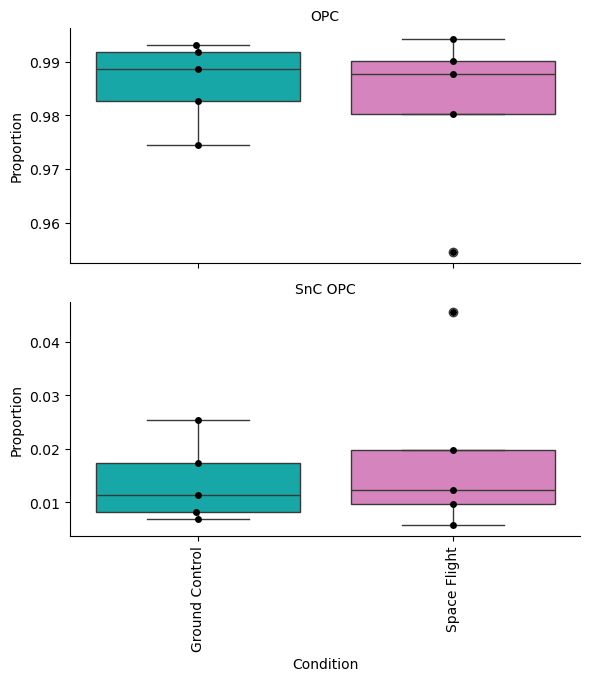

sample: 100%|█| 12000/12000 [01:00<00:00, 196.95it/s, 1 steps of size 9.36e-02.

! Acceptance rate unusually low (0.33537718495149665 < 0.5)! Results might be incorrect! Please check feasibility of results and re-run the sampling step with a different rng_key if necessary.


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 10 samples, 2 cell types                                          │
│ Reference cell type                   │ OPC                                                                     │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 33.5%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ OPC                               7.377        4.687   9.433   1.134     258.051                                │
│ SnC OPC                           2.678        0.301   4.729   1.056       2.349                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                           Final Parameter  Expected Sample  log2-fold change                                    │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight OPC            0.000           258.051            0.000                                          │
│                SnC OPC        0.000             2.349            0.000                                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                           HDI 3%  HDI 97%   SD    Inclusion probability                                         │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight OPC         0.000   0.000   0.000         0.000                                                  │
│                SnC OPC    -0.017  47.301  27.720         0.750                                                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate Condition[T.Space Flight]
Cell Type                          
OPC                                
SnC OPC                            




Seed = 0; 10000 samples; 10000 warmup
• Zero counts encountered in data! Added a pseudocount of 0.5.


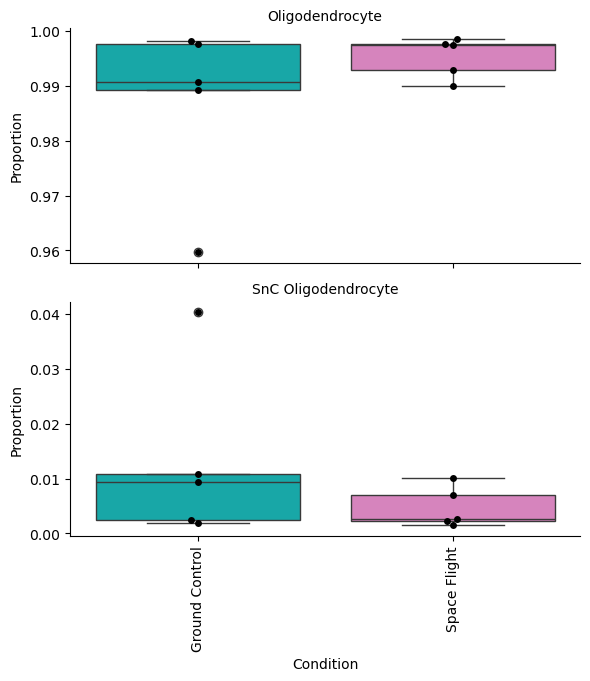

sample: 100%|█| 12000/12000 [01:02<00:00, 193.28it/s, 9 steps of size 2.13e-01.


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 10 samples, 2 cell types                                          │
│ Reference cell type                   │ Oligodendrocyte                                                         │
│ Formula                               │ Condition                                                               │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (2000 burnin samples)                        │
│ Acceptance rate                       │ 79.9%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                               Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                           │
│ Senescent_Cell_Label_by_Type                                                                                    │
│ Oligodendrocyte                   4.717         3.454  6.013   0.687     944.771                                │
│ SnC Oligodendrocyte               0.072        -0.922  1.109   0.548       9.079                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     Final Parameter  Expected Sample  log2-fold change                          │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Oligodendrocyte          0.000           944.771            0.000                                │
│                SnC Oligodendrocyte      0.000             9.079            0.000                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     HDI 3%  HDI 97%   SD   Inclusion probability                                │
│ Covariate      Cell Type                                                                                        │
│ T.Space Flight Oligodendrocyte       0.000  0.000   0.000         0.000                                         │
│                SnC Oligodendrocyte  -0.972  0.482   0.268         0.432                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



==================================================   Credible Effects   ==================================================

 Covariate           Condition[T.Space Flight]
Cell Type                                    
Oligodendrocyte                              
SnC Oligodendrocyte                          




Seed = 8675309; 10000 samples; 10000 warmup
• Zero counts encountered in data! Added a pseudocount of 0.5.


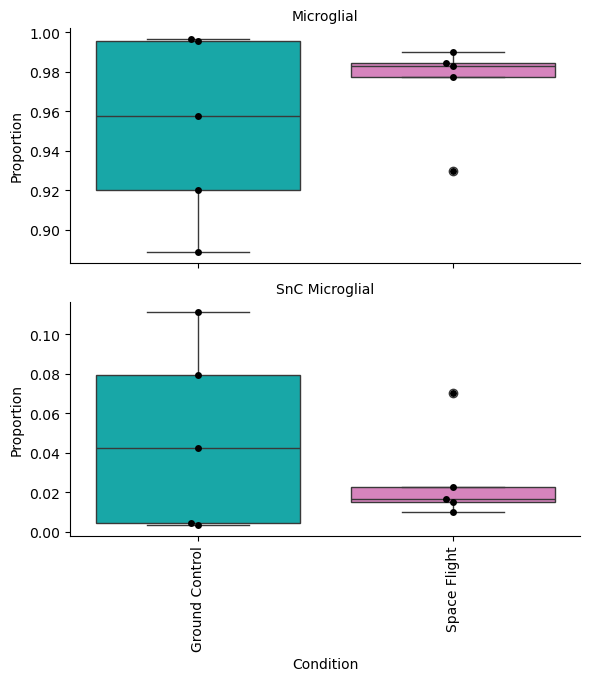

sample:  50%|▌| 6023/12000 [19:16<19:07,  5.21it/s, 1023 steps of size 7.39e-13


KeyboardInterrupt: 

In [38]:
for x in self.rna.obs[col_celltype].unique():
    r_s, num_samples, num_warmup = 0, 10000, 2000  # defaults
    if "annotation_scanvi" in col_celltype:  # avoid bad acceptance rates
        r_s = 16 if x  == "OPC" else 8675309 if x in [
            "Microglial"] else r_s  # different random seed
        if x == "Endothelial":
            r_s, num_samples, num_warmups = 7654321, 14000, 2000
    print(f"Seed = {r_s}; {num_samples} samples; {num_samples} warmup")
    out = scflow.ax.analyze_composition(
        self.rna[self.rna.obs[col_celltype] == x],
        "Senescent_Cell_Label_by_Type", col_condition,
        col_sample=col_sample, formula=None, key_modality="coda",
        full_hmc=False, palette=palette[col_condition], seed=r_s,
        num_samples=10000, num_warmup=2000,
        reference_cell_type=x, absence_threshold=0.1, est_fdr=0.2,
        level_order=[keys[col_condition]["key_control"], keys[
            col_condition]["key_treatment"]])
    f_sccoda_out = f"outputs/sccoda_results_{col_celltype}_{x}_sfgc.pkl"
    if overwrite is True or os.path.exists(f_sccoda_out) is False:
        with open(f_sccoda_out, "wb") as f:
            pickle.dump(out[0], f)
        # out[1].write_h5mu(
        #     f"outputs/sccoda_data_{col_celltype}_{x}_sfgc.h5mu")
    plt.show()
    del out

##### Lower SnC Threshold

In [ ]:
chp = f"Senescent_Cell_Label_by_Type_{use_metric}_{p_h}"  # column name
print("Cross-Tabs of Cell Counts in SnC Classifications "
      f"with Top {percentile}% Threshold versus Top {p_h}%")
print(self.rna.obs[["Senescent_Cell_Label_by_Type", chp]].value_counts(
    ).sort_index(), "\n\n")  # cross-tabs of higher vs. lower SnC threshold
# print(self.rna.obs[["Senescent_Cell_Label_by_Type", chp, col_batch]].groupby(
#     col_batch).value_counts().unstack(0).replace(0, np.nan).dropna(
#         how="all", axis=0).astype(int).sort_index())  # cross-tabs by group
for x in self.rna.obs[col_celltype].unique():
    out = scflow.ax.analyze_composition(
        self.rna[self.rna.obs[col_celltype] == x],
        chp, col_condition, col_sample=col_sample,
        formula=None, key_modality="coda", full_hmc=False,
        palette=palette[col_condition], seed=1618,
        num_samples=10000, num_warmup=2000,
        reference_cell_type=x, absence_threshold=0.1, est_fdr=0.2,
        level_order=[keys[col_condition]["key_control"], keys[
            col_condition]["key_treatment"]])
    f_sccoda = f"outputs/sccoda_results_{col_celltype}_{x}_sfgc_{p_h}pct.pkl"
    if overwrite is True or os.path.exists(f_sccoda) is False:
        with open(f_sccoda, "wb") as f:
            pickle.dump(out[0], f)
        out[1].write_h5mu(
            f"outputs/sccoda_data_{col_celltype}_{x}_sfgc_{p_h}pct.h5mu")
    plt.show()
    del out

## Differential Gene Expression

Mainly using `edgeR`

### Pseudo-Bulk & Examine Covariates

In [ ]:
pdata = scflow.tl.create_pseudobulk(
    self.rna, [i for i in [col_sample, col_condition, col_age] if i],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pdata.layers["counts"] = pdata.X.copy()
sc.pp.normalize_total(pdata, target_sum=1e6)
sc.pp.log1p(pdata)
sc.pp.pca(pdata)
sc.pl.pca(pdata, color=pdata.obs, ncols=1, size=300)

### Overall DEGs by Groups

#### Age

**In older spaceflight mice compared to younger spaceflight mice**
* 9630013a20Rik (CNS myelination and neural tissue regeneration) is downregulated.
* mt-Td is upregulated.

In [ ]:
%matplotlib inline

# Overall
print(f"\n\n{'=' * 80}\nOverall Sample\n{'=' * 80}\n\n")
out_edgr_age = scflow.ax.run_deg_edgr(
    self.rna, col_age, col_covariate=None, formula=None,
    **keys[col_age], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title="Age DEGs: Overall Sample\n\n")

# Ground Control Subset
print(f"\n\n{'=' * 80}\nGround Control Subset\n{'=' * 80}\n\n")
out_edgr_age_gc = scflow.ax.run_deg_edgr(
    self.rna[self.rna.obs[col_condition] == keys[
        col_condition]["key_control"]],
    col_age, col_covariate=None, formula=None,
    **keys[col_age], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title="Age DEGs: Just Ground Control\n\n")

# Space Flight Subset
print(f"\n\n{'=' * 80}\nSpace Flight Subset\n{'=' * 80}\n\n")
out_edgr_age_sf = scflow.ax.run_deg_edgr(
    self.rna[self.rna.obs[col_condition] == keys[
        col_condition]["key_treatment"]],
    col_age, col_covariate=None, formula=None, **keys[col_age],
    log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype,
    col_sample=col_sample, fig_title="Age DEGs: Just Space Flight\n\n")

#### Condition

```
out_edgr_con_o[0][(out_edgr_con_o[0].adj_p_value < 0.01) & (
    out_edgr_con_o[0].abs_log_fc > 0.5)].sort_values(
        "abs_log_fc", ascending=False)
```

Among the older mice, *Mir6236* was differentially highly expressed in aged spaceflight mice compared to ground control mice (LFC=1.95, adjusted p=2.61e-13 in the overall sample; LFC=2.11, adjusted p=0.000015 in the aged subset). Suppression of this gene has been linked to neuronal morphogenesis (https://pubs.acs.org/doi/abs/10.1021/acsabm.0c01389) and therefore may represent a candidate intervention target. 

*Il31ra*, which has been linked to neuroinflammation (https://advanced.onlinelibrary.wiley.com/doi/pdfdirect/10.1002/advs.202409086), was also more highly expressed in spaceflight mice compared to ground control mice (LFC=1.52, adjusted p<0.001 in the overall sample; LFC=1.53, adjusted p<0.001 in the aged subset).

*UBA52*, also more highly expressed in spaceflight mice (LFC=1.43, adjusted p<0.001 in the overall sample; LFC=1.45, adjusted p<0.001 in the aged subset), may serve a neuroprotective role: It has been shown underexpressed in PD (https://www.mdpi.com/2073-4409/11/23/3770) and plays a role in neuroautophagy (https://www.tandfonline.com/doi/pdf/10.1080/15548627.2024.2395727). Likewise, *Pomp*, a gene associated with oxidative stress resistance and protein clearance [CITATION] was also more highly expressed in spaceflight mice. In contrast to past observations of downregulation of *Uqcr11* in Alheimer's (https://www.benthamdirect.com/content/journals/car/10.2174/1567205014666170505095921), that gene was differentially highly expressed in spaceflight mice (LFC=1.23 aged subset; LFC=1.44 overall; p<0.001); however, *Cmss1*, which has been associated with Alzheimer's in APOE4 mice (https://pmc.ncbi.nlm.nih.gov/articles/PMC8064208/), was also more highly expressed in spaceflight mice.

Genes involved in oxidative phosphorylation and the electron transport chain, including *Atp5e*, *Ndufa12*, and *Uqcr11* were also more highly expressed in spaceflight mice. *Uqcr11* has shown an anti-apoptotic and oxidative stress alleviation role in mice (https://www.mdpi.com/2073-4425/16/5/526).

*Tpt1* and *Rn7sk* were also upregulated in spaceflight mice. *Tpt1*, which is associated with cancer progression, anti-apoptosis, and cell stress response, has been shown to have a potentially bi-directional relationship with cell cycle control gene and canonical senescence marker *TP53* (https://www.tandfonline.com/doi/pdf/10.4161/cc.25404). *Rn7sk* is associated with cellular senescence (https://onlinelibrary.wiley.com/doi/abs/10.1002/jcp.28119) and Alzheimer's (https://www.nature.com/articles/s41598-024-82490-9.pdf).

---

*Pvalb* overall sample (LFC=1.61, p=1.25e-11)

*Trim17*

*Cck*

*Pam16*

---

*Mitochondrial/electron transport chain genes whose upregulation has been linked to Parkinson's disease (https://pmc.ncbi.nlm.nih.gov/articles/PMC10259399/pdf/AMS-19-3-131629.pdf) and/or adaptive responses to neurodegeneration in Alheimer's mouse models (https://journals.sagepub.com/doi/abs/10.1177/13872877251314847), including *mt-Atp6*, *mt-Co1*, *mt-Cytb* *mt-Nd2*, and *mt-Nd5*, *mt-Nd6...pregulation of *mt-Rnr1*, which also showed higher expression in spaceflight aged mice, has been seen in response to ionizing radiation, possibly reflecting increased mitochonrial biogenesis as an adaptive stress response (https://pmc.ncbi.nlm.nih.gov/articles/PMC5555881)** 

In [ ]:
# Overall
print(f"\n\n{'=' * 80}\nOverall Sample\n{'=' * 80}\n\n")
out_edgr_con = scflow.ax.run_deg_edgr(
    self.rna, col_condition, col_covariate=None, formula=None,
    **keys[col_condition], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title=f"{col_condition} DEGs (Overall Sample)\n\n")
out_edgr_con_df = out_edgr_con[0][out_edgr_con[
    0].adj_p_value < 0.001].sort_values("abs_log_fc", ascending=False)
goe = out_edgr_con_df.variable[:10].to_list()
print(out_edgr_con_df.iloc[:min(100, out_edgr_con_df.shape[0])], "\n\n", goe)
plt.show()

# Just Old
print(f"\n\n{'=' * 80}\nAged Subset\n{'=' * 80}\n\n")
out_edgr_con_o = scflow.ax.run_deg_edgr(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]],
    col_condition, col_covariate=None, formula=None,
    **keys[col_condition], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title=f"{col_condition} DEGs (Just Aged)\n\n")
plt.show()
out_edgr_con_o_df = out_edgr_con_o[0][out_edgr_con_o[
    0].adj_p_value < 0.001].sort_values("abs_log_fc", ascending=False)
goes = out_edgr_con_o_df.variable[:10].to_list()
print(out_edgr_con_o_df, "\n\n", goes)
_ = self.plot(
    kind=["violin", "matrix"], col_celltype=col_batch, layer="log1p",
    violin=dict(col_wrap=5, hspace=0.25, rotation=45, figsize=(20, 20)),
    matrix=dict(standard_scale="var"), genes=goes)
out_edgr_old_sf_v_gc = out_edgr_con_o_df[0][(
    out_edgr_con_o_df[0].abs_log_fc > 1) & (
        out_edgr_con_o_df[0].adj_p_value < 0.001)].sort_values(
            "adj_p_value", ascending=True)
out_edgr_old_sf_v_gc = out_edgr_old_sf_v_gc.groupby("contrast").apply(
    lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
        :20]).set_index("variable", append=True).reset_index(
            1, drop=True).rename_axis([col_condition, "variable"])
out_edgr_con_compare = out_edgr_con_o_df.set_index("variable")[[
    "log_fc", "adj_p_value"]].join(out_edgr_con_df.set_index("variable")[[
        "log_fc", "adj_p_value"]], how="inner", lsuffix="_Aged_Subset",
                                   rsuffix="_Overall_Sample")
out_edgr_con_compare

#### Age x Condition

Spaceflight effect (main analysis), can visualize at different ages

*Chchd2* (related to oxidative phosphorylation, cell migration, apoptosis inhibition, COX regulation, stress adaptation, Parkinson's, Lewy Body diseases, and cancer) was more highly expressed in spaceflight mice (and demonstrated a bigger young versus old difference in spaceflight mice).
Spaceflight mice also showed higher expression of several ribosomal proteins (*Rps16*, *Rpl31*, *Rpl17*, *Rpl9*, *Rpl15*, *Rps15a*, *Rpl19*, *Rps7*, *Rps23*, *Rpl37*, *Rps3a1*, *Rpl29*, *Rps15*, *Rps14*).

*Ndufa4* was also more highly expressed (implicated in cancer and mitochondrial dysfunction, part of the cytochrome c oxidase complex which drives oxidative phosphorylation, adaptation to hypoxia via downregulation of oxygen consumption and suppression of mitochondrial ROS production https://www.cell.com/cell-metabolism/fulltext/S1550-4131(11)00394-9?mobileUi=0) in spaceflight mice, as were other genes involved in ATP production/the electron transport chain and oxidative phosophorylation, including *Cox7a2*, *Uqcr11*, *Ndufa12*, *Ndufa4*, *Ndufc1*, *Atp5o-1*, *Atp5e*, and *Uqcrh* (which additionally has been implicated in tumor suppression https://aacrjournals.org/cancerres/article/80/16_Supplement/4795/643367).


In [ ]:
# With Single Label for Age x Condition
print(f"\n\n{'=' * 80}\nGroup (Single Factor)\n{'=' * 80}\n\n")
out_edgr_groups = scflow.ax.run_deg_edgr(
    self.rna, col_batch, col_covariate=None, formula=None,
    **keys[col_batch], col_sample=col_sample,
    log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype)
print(list(out_edgr_groups[0].variable[:25]))
plt.show()
# _ = self.plot(kind="violin", col_celltype=col_batch,
#               genes=list(out_edgr_groups[0].variable[:25]), layer="scaled",
#               violin=dict(col_wrap=4, hspace=1, rotation=45))
out_edgr_batches = out_edgr_groups[0][(out_edgr_groups[0].abs_log_fc > 1) & (
    out_edgr_groups[0].adj_p_value < 0.001)].sort_values(
        "adj_p_value", ascending=True)
out_edgr_batches_top = out_edgr_batches.groupby("contrast").apply(
    lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
        :20]).set_index("variable", append=True).reset_index(
            1, drop=True).rename_axis([col_condition, "variable"])

# With Contrasts (Age & Condition = Separate Factors)
print(f"\n\n{'=' * 80}\nAge * Condition (2-Factor Contrast)\n{'=' * 80}\n\n")
out_edgr_contrasts = scflow.ax.run_deg_edgr(
    self.rna, col_condition, col_covariate=col_age, formula=None,
    **keys[col_condition], log2fc_thresh=0, n_top_vars=24,
    col_celltype=col_celltype, col_sample=col_sample)
_ = self.plot(
    kind=["violin", "matrix"], col_celltype=col_batch,
    genes=out_edgr_contrasts[0][out_edgr_contrasts[
        0].adj_p_value < 0.001].sort_values(
            "abs_log_fc", ascending=False).variable[:10], layer="log1p",
    violin=dict(col_wrap=5, hspace=0.25, rotation=45, figsize=(20, 20)),
    matrix=dict(standard_scale="var"))

# Condition x Age
# Vulnerability of mice who were older at launch to spaceflight stress
out_edgr_contrasts_age = scflow.ax.run_deg_edgr(
    self.rna, col_age, col_covariate=col_condition, formula=None,
    **keys[col_age], log2fc_thresh=0, n_top_vars=24,
    col_celltype=col_celltype, col_sample=col_sample)

#### Senescence Gene Contrasts Results

In [ ]:
# Genes
sen_genes_in_contrasts = list(set(genes).intersection(
    out_edgr_contrasts[0].variable.unique()))  # senescence genes in contrasts
out_edgr_snc = out_edgr_contrasts[0].set_index(
    "variable").loc[sen_genes_in_contrasts]  # contrast results for snc genes
res_snc_contrast = out_edgr_snc[out_edgr_snc.adj_p_value < 0.01]  # p < 0.01
sig_contrast_genes = list(res_snc_contrast.index.values)  # significant genes

# Plots By Groups; Axis by Cell Types
kws = dict(dot=dict(figsize=(10, 5)), heat=dict(figsize=(15, 15)))
_ = self.plot(kind=["matrix", "dot"], genes=sig_contrast_genes,
              standard_scale="obs", col_celltype=col_celltype,
              by_group=col_batch, **kws)

# Plots By Cell Types; Axis by Groups
# kws = dict(dot=dict(figsize=(10, 5)), heat=dict(figsize=(15, 15)),
#            violin=dict(figsize=(30, 20), col_wrap=4, xlabel=None,
#                        rotation=45, hspace=1, top=0.95))
kws = dict(dot=dict(figsize=(10, 5)), heat=dict(figsize=(15, 15)))
_ = self.plot(kind=["matrix", "dot"], genes=sig_contrast_genes,
              standard_scale="obs", col_celltype=col_batch,
              by_group=col_celltype, **kws)

# Results
print(f"\n{'=' * 80}\nSignificant Senescence Gene Contrasts\n{'=' * 80}\n")
print(sig_contrast_genes)
res_snc_contrast

### Snc versus Not (Group=Covariate)

In [ ]:
# Group = Covariate
out_edgr_contrasts_snc = scflow.ax.run_deg_edgr(
    self.rna, "Senescent_Cell_Label",
    col_covariate=col_batch, formula=None,
    key_treatment="Senescent", key_control="Non-Senescent",
    log2fc_thresh=0, n_top_vars=24, xlabel_rotation=45,
    hspace=0.5, wspace=0.2, top=0.92, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)

### SnC versus Not SnC (Group=Subset)

In [ ]:
# Aged Subset
subset_old = self.rna.obs[col_age] == keys[col_age]["key_treatment"]

# Old Ground Control SnCs
print(f"\n\n{'=' * 80}\nGround Control (Aged)\n{'=' * 80}\n\n")
subset_gc = self.rna.obs[col_condition] == keys[
    col_condition]["key_control"]
out_edgr_contrasts_snc_gc = scflow.ax.run_deg_edgr(
    self.rna[subset_gc & subset_old], "Senescent_Cell_Label",
    key_treatment="Senescent", top=0.92,
    key_control="Non-Senescent", log2fc_thresh=0, n_top_vars=24,
    xlabel_rotation=45, hspace=0.5, wspace=0.2, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)
if len(self.rna[subset_gc & subset_old].obs[col_batch].unique()) > 1:
    raise ValueError("Check subsetting")
key_1 = self.rna[subset_gc & subset_old].obs[col_batch].unique()[0]

# Old Spaceflight SnCs
print(f"\n\n{'=' * 80}\nSpaceflight (Aged)\n{'=' * 80}\n\n")
subset_sf = self.rna.obs[col_condition] == keys[
    col_condition]["key_treatment"]
out_edgr_contrasts_snc_sf = scflow.ax.run_deg_edgr(
    self.rna[subset_sf & subset_old], "Senescent_Cell_Label",
    key_treatment="Senescent", key_control="Non-Senescent",
    log2fc_thresh=0, n_top_vars=24, xlabel_rotation=45,
    hspace=0.5, wspace=0.2, top=0.92, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)
if len(self.rna[subset_sf & subset_old].obs[col_batch].unique()) > 1:
    raise ValueError("Check subsetting")
key_2 = self.rna[subset_sf & subset_old].obs[col_batch].unique()[0]

# Compare
res_snc_gc = out_edgr_contrasts_snc_gc[0][out_edgr_contrasts_snc_gc[
    0].adj_p_value < 0.001].sort_values("adj_p_value").set_index("variable")
res_snc_sf = out_edgr_contrasts_snc_sf[0][out_edgr_contrasts_snc_sf[
    0].adj_p_value < 0.001].sort_values("adj_p_value").set_index("variable")
res_snc_grps = pd.concat([
    res_snc_gc, res_snc_sf], keys=[key_1, key_2], names=[col_condition])
res_snc_grps = res_snc_grps[res_snc_grps.abs_log_fc >= 1]
# top_tx_g_snc = res_snc_grps.loc[keys[col_condition][
#     "key_treatment"]].sort_values("abs_log_fc", ascending=False).index
# print(res_snc_grps.unstack(0).replace(np.nan, "")[[
#     "log_fc", "adj_p_value"]].loc[top_tx_g_snc])
# just_sf = res_snc_grps.loc[keys[col_condition][
#     "key_treatment"]].index.difference(res_snc_grps.loc[keys[
#         col_condition]["key_control"]].index)
# just_gc = res_snc_grps.loc[keys[col_condition][
#     "key_control"]].index.difference(res_snc_grps.loc[keys[
#         col_condition]["key_treatment"]].index)
# print(res_snc_grps.loc[:, just_gc, :].sort_values(
#     "abs_log_fc", ascending=False)[["log_fc", "adj_p_value"]], "\n\n")
# res_snc_grps.loc[:, just_sf, :].sort_values(
#     "abs_log_fc", ascending=False)[["log_fc", "adj_p_value"]]
res_snc_grps.unstack(0).replace(np.nan, "")[["log_fc", "adj_p_value"]]

### Group DEGs (SnC=Covariate)

In [ ]:
out_edgr_contrasts_snc_cov = {}
for a in self.rna.obs[col_age].unique():
    print(f"\n\n{'=' * 80}\nAge = {a}\n{'=' * 80}\n\n")
    out_edgr_contrasts_snc_cov[a] = scflow.ax.run_deg_edgr(
        self.rna[self.rna.obs[col_age] == a], col_condition,
        col_covariate="Senescent_Cell_Label",
        **keys[col_condition], log2fc_thresh=0, n_top_vars=24,
        xlabel_rotation=45, hspace=0.5, wspace=0.2, top=0.85,
        legend_loc="upper right", col_celltype=col_celltype,
        col_sample=col_sample)
    plt.show()

### Group DEGs (SnC=Subset)

##### All Groups SnCs

In [ ]:
out_edgr_groups_snc = scflow.ax.run_deg_edgr(
    self.rna[(self.rna.obs["Senescent_Cell_Label"] == "Senescent")],
    col_batch, **keys[col_batch], col_sample=col_sample,
    log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype)
print(list(out_edgr_groups[0].variable[:25]))
out_edgr_batches_snc = out_edgr_groups[0][(
    out_edgr_groups[0].abs_log_fc > 1) & (
        out_edgr_groups[0].adj_p_value < 0.001)].sort_values(
            "adj_p_value", ascending=True)
out_edgr_batches_top = out_edgr_batches.groupby("contrast").apply(
    lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
        :20]).set_index("variable", append=True).reset_index(
            1, drop=True).rename_axis([col_condition, "variable"])
plt.show()

##### Just Aged SnCs

In [ ]:
out_edgr_contrasts_sncto, snc_degs_by_condition_age_ct = {}, {}
thresh_p_c, thresh_lfcabs_c = 0.05, 0.5  # thresholds
subs_old = self.rna.obs[col_age] == keys[col_age]["key_treatment"]
subs_sf = self.rna.obs[col_condition] == keys[col_condition]["key_treatment"]
# subs_ac = (self.rna.obs["Senescent_Cell_Label"] == "Senescent") & (
#     subs_old | subs_sf)
subs_ac = (self.rna.obs["Senescent_Cell_Label"] == "Senescent") & (subs_old)
out_edgr_contrasts_sncto["Overall"] = scflow.ax.run_deg_edgr(
        self.rna[subs_ac], col_condition,
        # col_covariate=col_age,
        **keys[col_condition],
        log2fc_thresh=0, n_top_vars=24,
        legend_loc="upper center", fig_title=f"Overall",
        wspace=0.25, bottom=0.3, hspace=1 if len(x) > 10 else 0.4, top=0.95,
        kws_xticks=dict(fontsize=10, rotation=45 if len(x) > 10 else None),
        col_celltype=col_celltype, col_sample=col_sample)
plt.show()
tmp = out_edgr_contrasts_sncto["Overall"][0]
tmp = tmp[(tmp.adj_p_value < thresh_p_c) & (
    tmp.abs_log_fc >= thresh_lfcabs_c)]  # filter by p & lfc
snc_degs_by_condition_age_ct["Overall"] = list(
    tmp.sort_values("adj_p_value", ascending=True).variable)
for x in self.rna.obs[col_celltype].unique():
    print(x)
    out_edgr_contrasts_sncto[x] = scflow.ax.run_deg_edgr(
        self.rna[(subs_ac) & (self.rna.obs[col_celltype] == x)],
        col_condition,
        # col_covariate=col_age,
        **keys[col_condition],
        log2fc_thresh=0, n_top_vars=24,
        legend_loc="upper center", fig_title=f"Senescent {x}",
        wspace=0.25, bottom=0.3, hspace=1 if len(x) > 10 else 0.4, top=0.95,
        kws_xticks=dict(fontsize=10, rotation=45 if len(x) > 10 else None),
        col_celltype=col_celltype, col_sample=col_sample)
    plt.show()
    tmp = out_edgr_contrasts_sncto[x][0]
    tmp = tmp[(tmp.adj_p_value < thresh_p_c) & (
        tmp.abs_log_fc >= thresh_lfcabs_c)]  # filter by p & lfc
    snc_degs_by_condition_age_ct[x] = list(tmp.sort_values(
            "adj_p_value", ascending=True).variable)
    del tmp
out_edgr_contrasts_snc_all_top = pd.concat([out_edgr_contrasts_sncto[x][
    0].set_index("variable").loc[snc_degs_by_condition_age_ct[
        x]] for x in out_edgr_contrasts_sncto], keys=out_edgr_contrasts_sncto,
                                           names=[col_celltype])
out_edgr_contrasts_snc_all = pd.concat([
    out_edgr_contrasts_sncto[x][0].set_index("variable")
    for x in out_edgr_contrasts_sncto], keys=out_edgr_contrasts_sncto,
                                       names=[col_celltype])
out_edgr_contrasts_snc_all_top

### More Specific Contrasts (`pyDESeq2`)

#### Group

In [ ]:
# pdata =  scflow.tl.create_pseudobulk(
#     self.rna, [col_sample, col_condition, col_age],
#     col_celltype, layer="counts", mode="sum")
# design = f"~{col_condition} + {col_age} + {col_condition} * {col_age}"
# # edgr = pt.tl.EdgeR(pdata, design=design)
# pds2 = pt.tl.PyDESeq2(adata=pdata, design=design)
# pds2.fit()
# key_control, key_treatment = [keys[col_condition][k] for k in [
#     "key_control", "key_treatment"]]
# key_control_cov, key_treatment_cov = [keys[col_age][k] for k in [
#     "key_control", "key_treatment"]]
# sf_old = {col_condition: key_treatment, col_age: key_treatment_cov}
# sf_yng = {col_condition: key_treatment, col_age: key_control_cov}
# gc_old = {col_condition: key_control, col_age: key_treatment_cov}
# gc_yng = {col_condition: key_control, col_age: key_control_cov}

# # Spaceflight-Specific Age DEGs
# spaceflight_specfic_age_degs = (pds2.cond(**sf_old) - pds2.cond(
#     **sf_yng)) - (pds2.cond(**gc_old) - pds2.cond(**gc_yng))
# interaction_res_df = pds2.test_contrasts(spaceflight_specfic_age_degs)
# pds2.plot_volcano(interaction_res_df, log2fc_thresh=0)

# # Age-Specific Spaceflight DEGs
# age_specfic_sf_degs = (pds2.cond(**sf_old) - pds2.cond(**gc_old)) - (
#     pds2.cond(**sf_yng) - pds2.cond(**gc_yng))
# interaction_res_df2 = pds2.test_contrasts(age_specfic_sf_degs)
# pds2.plot_volcano(interaction_res_df2, log2fc_thresh=0)

# # Old vs. Young Spaceflight
# age_sf_ix = pds2.cond(**sf_old) - pds2.cond(**sf_yng)
# interaction_res_df3 = pds2.test_contrasts(age_sf_ix)
# pds2.plot_volcano(interaction_res_df3, log2fc_thresh=0)

# # Old vs. Young GC
# age_gc_ix = pds2.cond(**gc_old) - pds2.cond(**gc_yng)
# interaction_res_df4 = pds2.test_contrasts(age_gc_ix)
# pds2.plot_volcano(interaction_res_df4, log2fc_thresh=0)

# # SF vs. GC Old
# cond_old_ix = pds2.cond(**sf_old) - pds2.cond(**gc_old)
# interaction_res_df5 = pds2.test_contrasts(cond_old_ix)
# pds2.plot_volcano(interaction_res_df5, log2fc_thresh=0)

# # SF vs. GC Young
# cond_yng_ix = pds2.cond(**sf_yng) - pds2.cond(**gc_yng)
# interaction_res_df6 = pds2.test_contrasts(cond_yng_ix)
# pds2.plot_volcano(interaction_res_df6, log2fc_thresh=0)

# # Compare
# thresh_lfc, thresh_p = 1, 0.001
# sf_deg_res_df_old = interaction_res_df5[(
#     interaction_res_df5.adj_p_value < thresh_p) & (
#         interaction_res_df5.log_fc.abs() >= thresh_lfc)].set_index(
#             "variable")
# sf_deg_res_df_yng = interaction_res_df6[(
#     interaction_res_df6.adj_p_value < thresh_p) & (
#         interaction_res_df6.log_fc.abs() >= thresh_lfc)].set_index(
#             "variable")
# sf_deg_res = pd.concat([sf_deg_res_df_old, sf_deg_res_df_yng],
#                        keys=["Old", "Young"], names=["Age Group"])
# sf_deg_res.loc[:, "log_fc_abs"] = sf_deg_res.log_fc.abs()
# sf_deg_res = sf_deg_res.sort_values("log_fc_abs", ascending=False)[[
#     "log_fc", "adj_p_value"]].unstack(0)
# print("SF DEGs in Both Young & Old: ", sf_deg_res.dropna().index.values)
# print("\n\nSF DEGs in Just Young", list(sf_deg_res_df_yng.index.difference(
#     sf_deg_res_df_old.index)), "\n\n")
# print("SF DEGs in Just Old", list(sf_deg_res_df_old.index.difference(
#     sf_deg_res_df_yng.index)), "\n\n")
# sf_deg_res.replace(np.nan, "")

# # Marker Set Overlap
# print("Both: ", marker_gene_sets.apply(
#     lambda i: set(sf_deg_res.dropna().index).intersection(set(i))).apply(
#         lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")
# print("Young: ", marker_gene_sets.apply(
#     lambda i: sf_deg_res_df_yng.index.difference(
#         sf_deg_res_df_old.index).intersection(set(i))).apply(
#         lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")
# print("Old: ", marker_gene_sets.apply(
#     lambda i: sf_deg_res_df_old.index.difference(
#         sf_deg_res_df_yng.index).intersection(set(i))).apply(
#         lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")

#### SnCs

##### Old

In [ ]:
# Setup
design = (f"~{col_condition} + Senescent_Cell_Label + "
          f"{col_condition} * Senescent_Cell_Label")
pdata2 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, "Senescent_Cell_Label"],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pds2_snc_old = pt.tl.PyDESeq2(adata=pdata2, design=design)
pds2_snc_old.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_treatment_cov}
sf_ns = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_control_cov}
gc_snc = {col_condition: key_control,
          "Senescent_Cell_Label": key_treatment_cov}
gc_ns = {col_condition: key_control, "Senescent_Cell_Label": key_control_cov}

# SnC DEGs
res_df_snc = pds2_snc_old.test_contrasts(pds2_snc_old.contrast(
    column="Senescent_Cell_Label", baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc[res_df_snc.adj_p_value < 0.001].head(10))
pds2_snc_old.plot_volcano(res_df_snc, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs = (pds2_snc_old.cond(
    **sf_sc) - pds2_snc_old.cond(**sf_ns)) - (
        pds2_snc_old.cond(**gc_snc) - pds2_snc_old.cond(**gc_ns))
interaction_res_df_snc_sf = pds2_snc_old.test_contrasts(
    spaceflight_specfic_snc_degs)
print(interaction_res_df_snc_sf[
    interaction_res_df_snc_sf.adj_p_value < 0.001].head(10))
pds2_snc_old.plot_volcano(interaction_res_df_snc_sf, log2fc_thresh=0)

##### Young

In [ ]:
# Setup
design = (f"~{col_condition} + Senescent_Cell_Label + "
          f"{col_condition} * Senescent_Cell_Label")
pdata2 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, "Senescent_Cell_Label"],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pds2_snc_yng = pt.tl.PyDESeq2(adata=pdata2, design=design)
pds2_snc_yng.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_treatment_cov}
sf_ns = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_control_cov}
gc_snc = {col_condition: key_control,
          "Senescent_Cell_Label": key_treatment_cov}
gc_ns = {col_condition: key_control, "Senescent_Cell_Label": key_control_cov}

# SnC DEGs
res_df_snc = pds2_snc_yng.test_contrasts(pds2_snc_yng.contrast(
    column="Senescent_Cell_Label", baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc[res_df_snc.adj_p_value < 0.001].head(10))
pds2_snc_yng.plot_volcano(res_df_snc, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs = (pds2_snc_yng.cond(
    **sf_sc) - pds2_snc_yng.cond(**sf_ns)) - (
        pds2_snc_yng.cond(**gc_snc) - pds2_snc_yng.cond(**gc_ns))
interaction_res_df_snc_sf = pds2_snc_yng.test_contrasts(
    spaceflight_specfic_snc_degs)
pds2_snc_yng.plot_volcano(interaction_res_df_snc_sf, log2fc_thresh=0)

#### SnCs (More Permissive Threshold)

In [ ]:
# Compare Less & More Permissive Thresholds
print("Less & More Permissive SnC Threshold: ", self.rna.obs[[
    "Senescent_Cell_Label", f"Senescent_Cell_Label_{use_metric}_{p_h}"
    ]].value_counts())
sen_lab = f"Senescent_Cell_Label_{use_metric}_{p_h}"

# Setup
design = (f"~{col_condition} + {sen_lab} + "
          f"{col_condition} * {sen_lab}")
pdata2_3 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, sen_lab],
    col_celltype, layer="counts", mode="sum")
pds2_snc_old_3 = pt.tl.PyDESeq2(adata=pdata2_3, design=design)
pds2_snc_old_3.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment, sen_lab: key_treatment_cov}
sf_ns = {col_condition: key_treatment, sen_lab: key_control_cov}
gc_snc = {col_condition: key_control, sen_lab: key_treatment_cov}
gc_ns = {col_condition: key_control, sen_lab: key_control_cov}

# SnC DEGs
res_df_snc_3 = pds2_snc_old_3.test_contrasts(pds2_snc_old_3.contrast(
    column=sen_lab, baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc_3[res_df_snc_3.adj_p_value < 0.001].head(10))
pds2_snc_old_3.plot_volcano(res_df_snc_3, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs_3 = (pds2_snc_old_3.cond(
    **sf_sc) - pds2_snc_old_3.cond(**sf_ns)) - (
        pds2_snc_old_3.cond(**gc_snc) - pds2_snc_old_3.cond(**gc_ns))
interaction_res_df_snc_sf_3 = pds2_snc_old_3.test_contrasts(
    spaceflight_specfic_snc_degs_3)
pds2_snc_old_3.plot_volcano(interaction_res_df_snc_sf_3, log2fc_thresh=0)

### MAST

In [ ]:
# %%R
# find_de_MAST_RE <- function(adata_, formula){
#     # create a MAST object
#     sca <- SceToSingleCellAssay(adata_, class="SingleCellAssay")
#     print("Dimensions before subsetting:")
#     print(dim(sca))
#     print("")
#     # keep genes that are expressed in more than 10% of all cells
#     sca <- sca[freq(sca) > 0.1,]
#     print("Dimensions after subsetting:")
#     print(dim(sca), "\n")
#     cdr2 <- colSums(assay(sca) > 0)
#     colData(sca)$ngeneson <- scale(cdr2)
#     # store the columns that we are interested in as factors
#     label <- factor(colData(sca)$label)
#     # set the reference level
#     label <- relevel(label,"ctrl")
#     colData(sca)$label <- label
#     celltype <- factor(colData(sca)$cell_type)
#     colData(sca)$celltype <- celltype
#     # same for donors (which we need to model random effects)
#     replicate <- factor(colData(sca)$replicate)
#     colData(sca)$replicate <- replicate
#     # create a group per condition-celltype combination
#     colData(sca)$group <- paste0(colData(
#         adata_)$label, ".", colData(adata_)$cell_type)
#     colData(sca)$group <- factor(colData(sca)$group)
#     # define and fit the model
#     zlmCond <- zlm(formula=formula,
#                    sca=sca,
#                    method="glmer",
#                    ebayes=F,
#                    strictConvergence=F,
#                    fitArgsD=list(nAGQ = 0)) # to speed up calculations
#     # perform likelihood-ratio test for the condition
#     summaryCond <- summary(zlmCond, doLRT="groupstim.CD14_Monocytes")
#     # get the table with log-fold changes and p-values
#     summaryDt <- summaryCond$datatable
#     return(summaryDt)
# }

# SnC GEX Profiles

## Pathway Analysis

In [ ]:
names = gp.get_library_name()
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              "MSigDB_Hallmark_2020",  # "DGIdb_Drug_Targets_2024",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reimport pdb;actome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
gene_sets = dict(zip(["up", "down"], [[
    f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
        f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
    for i in ["up", "down"]]))


def fx_replace_string(string):
    """Make short version of pathway terms."""
    string = re.sub("aging:([0-9]+)", "aging", re.sub(
        "([0-9]+) months v ([0-9]+) mo(nths)?", "\\1 v \\2 mo.", re.sub(
            "SRP[0-9]+ ", "", re.sub("GSE[0-9]+ ", "", string))))
    string = re.sub(".*.xlsx.", "", re.sub(
        ".*Supplementary Data ..", "", re.sub(
            "PMID([0-9])+", "", re.sub("([0-9]+) years v ([0-9]+) years",
                                       "\\1 v \\2 yrs.", string))))
    string = re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
        ".*.XLSX", "", re.sub(
            ".*Supplementary Table [0-9]+[-]?", "", string))))
    return string

### Endrichr

In [ ]:
out_pathway_snc_edgr_contrasts = scflow.ax.run_enrichr(
    out_edgr_contrasts_snc_all_top, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string, title="Overall")

### SnC vs. Not

In [ ]:
# res_dc_ulm = scflow.ax.run_decoupler_ulm(
#         self.rna[self.rna.obs["Senescent_Cell_Label"] == "Senescent"],
#         # "Senescent_Cell_Label_by_Type",
#         # "Senescent_Cell_Label",
#         col_condition, col_condition="Senescent_Cell_Label_by_Type",
#         species=species, resource="hallmark",
#         top=0.95, hspace=1, wspace=0.5, figsize=(15, 10))

#### Pathway Set = Progeny

In [ ]:
res_dc_ulm = scflow.ax.run_decoupler_ulm(
        self.rna[self.rna.obs["Senescent_Cell_Label"] == "Senescent"],
        col_condition, col_condition="Senescent_Cell_Label_by_Type",
        species=species, resource="progeny",
        hspace=0.5, wspace=0.5, top=0.95, figsize=(15, 15))
res_dc_ulm_scores = pd.concat([res_dc_ulm[0][x][1].set_index(
    "group").rename_axis(col_condition).set_index(
        "name", append=True) for x in res_dc_ulm[0]],
                              keys=res_dc_ulm[0], names=[col_celltype])
res_dc_ulm_pathways = pd.concat([pd.Series(res_dc_ulm[0][x][2])
                                 for x in res_dc_ulm[0]], keys=res_dc_ulm[0])
print(res_dc_ulm_pathways)
res_dc_ulm_scores

#### Pathway Set = Hallmark

In [ ]:
res_dc_ulm_hm = scflow.ax.run_decoupler_ulm(
        self.rna[self.rna.obs["Senescent_Cell_Label"] == "Senescent"],
        col_condition, col_condition="Senescent_Cell_Label_by_Type",
        species=species, resource="hallmark",
        hspace=0.5, top=0.95, figsize=(15, 15))
res_dc_ulm_hm_scores = pd.concat([res_dc_ulm_hm[0][x][1].set_index(
    "group").rename_axis(col_condition).set_index(
        "name", append=True) for x in res_dc_ulm_hm[0]],
                                 keys=res_dc_ulm_hm[0], names=[col_celltype])
res_dc_ulm_hm_scores

### Individual Cell Scores

In [ ]:
res_aucell = scflow.ax.run_decoupler_aucell(
    self.rna, col_covariates=["Senescent_Cell_Label_by_Type", col_condition],
    resource="progeny", species=species, inplace=True)
_ = self.plot(genes=list(self.rna.obsm["score_aucell"].columns),
              subset=self.rna.obs["Senescent_Cell"],
              col_celltype=col_condition, kind="violin",
              by_group="Senescent_Cell_Label_by_Type", figsize=(15, 15))

#### DEGs (`find_markers`) by Group

In [ ]:
out_pathway_snc_degs = scflow.ax.run_enrichr(
    df_snc_markers_top, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string, title="Overall")
out_pathway_snc_degs_gc = scflow.ax.run_enrichr(
    df_snc_markers_top_gc, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string,
    title=keys[col_condition]["key_control"])
out_pathway_snc_degs_sf = scflow.ax.run_enrichr(
    df_snc_markers_top_sf, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string,
    title=keys[col_condition]["key_treatment"])
# out_pathway_snc_degs[1].drop("All", level=0)

#### Edger Contrasts (Pseudo-Bulk)

In [ ]:
# GSEA
print("\n\nGSEA Enrichment Analysis\n\n")
out_pathway_snc_degs = scflow.ax.run_enrichr(
    out_edgr_contrasts_snc_all_top, col_grouping=col_celltype,
    gene_sets=gene_sets, fx_replace_string=fx_replace_string)

# ToppGene
print("\n\nToppGene Enrichment Analysis\n\n")
mks_ctrsts_snc = dict(out_edgr_contrasts_snc_all_top.reset_index(
    1).variable.groupby(col_celltype).apply(lambda x: list(x)))  # SnC DEGs
results_toppgene_degs = scflow.pp.annotate_by_toppgene(
    mks_ctrsts_snc, species=species, min_genes=1,
    categories=["Pathway", "PubMed"])
results_toppgene_degs = results_toppgene_degs.join(pd.Series(
    mks_ctrsts_snc).to_frame("DEGs").rename_axis("Gene Set"))
results_toppgene_degs = results_toppgene_degs.groupby("Gene Set").apply(
    lambda x: x.sort_values("PValue", ascending=True), include_groups=False)
pthwys = dict(results_toppgene_degs.groupby("Gene Set").apply(
    lambda x: [i.capitalize() for i in x.Name.unique()]))
print("\n\n".join([f"{k}: {pthwys[k]}" for k in pthwys]))
results_toppgene_degs[["Name", "Symbols", "GenesInTerm", "GenesInQuery",
                       "GenesInTermInQuery", "PValue"]].reset_index(
                           2, drop=True)

## Plot

In [ ]:
# Top 10 Senescence Genes or All?
ggg = top_genes
# ggg = genes

# Mask for High Senescence Subset & Helper Variable for Figure Dimensions
subset = self.rna.obs["Senescent_Cell"].isin([1, True])
num_cts = len(self.rna[subset].obs[col_celltype].unique())

# Plot SnC Markers Overlap with Marker Sets
sc.pl.violin(self.rna[subset], set(genes).intersection(
    marker_gene_sets.explode().unique()),
             groupby=col_batch, rotation=90)  # plot overlap w/ SnC markers

# Plot Most Highly-Expressed Genes in Each Senescent Cell Type
_ = self.plot(kind=["matrix", "heat"], genes=top_genes,
              col_celltype=col_celltype, layer="log1p",
              subset=subset, dendrogram=True, swap_axes=False, heat=dict(
                  dendrogram=False), standard_scale="var",
              figsize=(len(top_genes) / 1.5, num_cts * 1.5))

# Grouped by Top Cell Types
_ = self.plot(kind=["matrix", "heat"], genes=top_genes_dict,
              standard_scale="obs", col_celltype=col_celltype,
              layer="log1p", swap_axes=False, figsize=(len(ggg), num_cts),
              subset=subset, dendrogram=True)

# Write Object

In [ ]:
# Send Email with Output When Done
if email is not None and html_out is not None:
    os.system(f"jupyter nbconvert --to html {cur_file}")
    os.system(f"echo 'yay' | mutt -s 'JOB DONE' -a {html_out} -- {email}")

if overwrite is True or os.path.exists() is False:
    self.rna.write_h5ad(file_path_new)
else:
    print(f"\n\n\n{'=' * 120}\nOVERWRITE IS FALSE..."
          f"NOT WRITING OBJECT!!!\n{'=' * 120}\n\n\n")

# SCRATCH

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()
df_degs = df_snc_markers.drop("All").reset_index(0, drop=True)

factor_name = col_celltype
# factor_name = col_condition

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
gene_sets = dict(zip(["up", "down"], [[
    f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
        f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
    for i in ["up", "down"]]))
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs", fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()

# factor_name = col_celltype
# factor_name = col_condition
factor_name = col_batch

df_degs = res_rank_genes_top.loc[:, "Overall", :]
df_degs = df_degs.assign(log_fc=df_degs.logfoldchanges.abs())
df_degs = df_degs.assign(abs_log_fc=df_degs.logfoldchanges_abs)

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs",
             fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()

factor_name = col_celltype
# factor_name = col_condition

iii = 2
df_degs = res_rank_genes_top.loc[self.rna.obs[col_batch].unique()[iii]]
df_degs = df_degs.assign(log_fc=df_degs.logfoldchanges.abs())
df_degs = df_degs.assign(abs_log_fc=df_degs.logfoldchanges_abs)
print(self.rna.obs[col_batch].unique()[iii])

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs", fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()

factor_name = col_celltype
# factor_name = col_condition

iii = 1
df_degs = res_rank_genes_top.loc[self.rna.obs[col_batch].unique()[iii]]
df_degs = df_degs.assign(log_fc=df_degs.logfoldchanges.abs())
df_degs = df_degs.assign(abs_log_fc=df_degs.logfoldchanges_abs)
print(self.rna.obs[col_batch].unique()[iii])

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs", fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]